## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'segmentAnything-full' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_horizontal_wavelet_full_segmentAnything.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\case-studies\\segmentAnything\\full\\wavelet\\horizontal\\gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 7072,
 3: 28288,
 4: 113152,
 5: 452608,
 6: 1810432,
 7: 7241728,
 8: 28966912,
 9: 115867648,
 10: 463470592}

Running 12760 CDFs


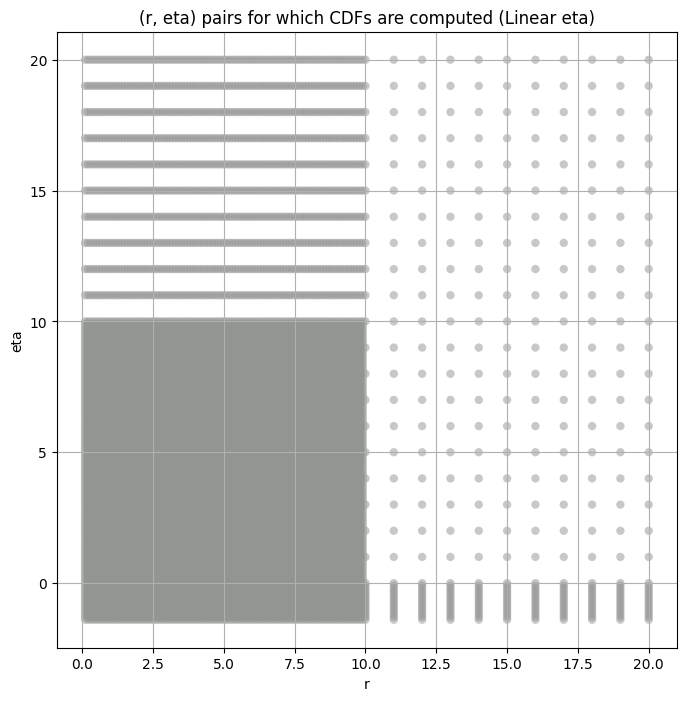

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 10


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      16354.510000  15633.312000  17082.553000   0.101962   -0.016666   
3       3922.895300   3744.966800   4103.727000   1.139715    0.928585   
4        930.998170    880.450900    983.070430   2.526734    2.019438   
5        218.603700    205.369100    232.632840   3.912470    2.933228   
6         49.854520     46.540530     53.384290   5.029304    3.773884   
7         11.294209     10.485279     12.181979   6.461322    4.597968   
8          2.590993      2.385578      2.849584   9.492075    5.469928   
9          0.616512      0.562501      0.693044  13.534157    6.594753   
10         0.148877      0.133936      0.172039  20.531488    8.519738   

       kurt_upper  total_samples  
layer                             
2        0.226260           7072  
3        1.379318          28288  
4        3.304371         113152  
5        7.310871         452608  
6        9.386376        1810432  
7       13.692297        7241728  
8       34.075478       28966912  
9       54.788080      115867648  
10      90.276040      463470592

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      16354.510000   16354.509766    15489.577148    14835.187500   
3       3922.895300    3922.895264     3821.143799     3746.247803   
4        930.998170     930.998169      916.760193      906.732971   
5        218.603700     218.603699      214.238159      211.482147   
6         49.854520      49.854519       48.704544       47.980350   
7         11.294209      11.294209       10.991048       10.807969   
8          2.590993       2.590993        2.505888        2.459400   
9          0.616512       0.616512        0.592588        0.580246   
10         0.148877       0.148877        0.141641        0.138088   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        14249.378906     13710.951172     12761.157227     11941.716797   
3         3679.585449      3617.855225      3505.400146      3402.385010   
4          897.994019       890.038940       875.576172       862.473267   
5          209.060577       206.864853       202.924637       199.390228   
6           47.360222        46.798779        45.797771        44.903885   
7           10.651251        10.510456        10.259711        10.037433   
8            2.419916         2.384501         2.321795         2.266533   
9            0.569783         0.560453         0.544020         0.529614   
10           0.135112         0.132482         0.127898         0.123929   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         11211.441406     10556.055664      9957.332031      8416.775391  
3          3307.583984      3219.797852      3138.243652      2920.076904  
4           850.418335       839.274902       828.815735       800.401855  
5           196.138367       193.121323       190.307312       182.737045  
6            44.085594        43.327282        42.617851        40.711918  
7             9.835382         9.648960         9.475189         9.010710  
8             2.216516         2.170505         2.127715         2.013873  
9             0.516647         0.504774         0.493779         0.464756  
10            0.120391         0.117181         0.114234         0.106565

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.043105258558855386 16354.51


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.04310644376122874 15489.577


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.04310723322094695 14835.1875


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.043109613416524806 14249.379


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.04311307351772575 13710.951


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.04327554738116146 12761.157


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.05067029735771622 11941.717


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.05780416914916575 11211.441


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.06473860090591299 10556.056


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.07160860992527607 9957.332


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.0916595229678846 8416.775
Number of samples: 7072, Without approximation : 7072


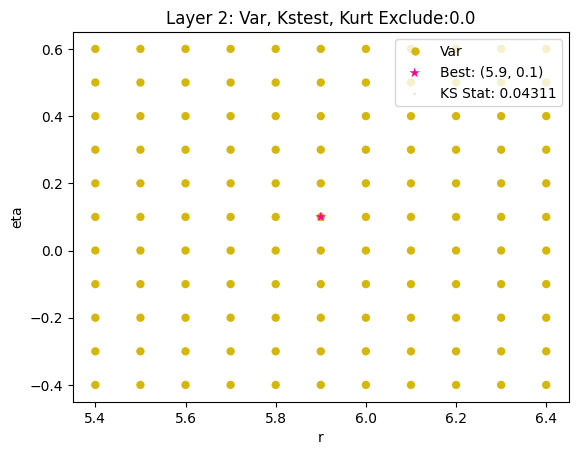

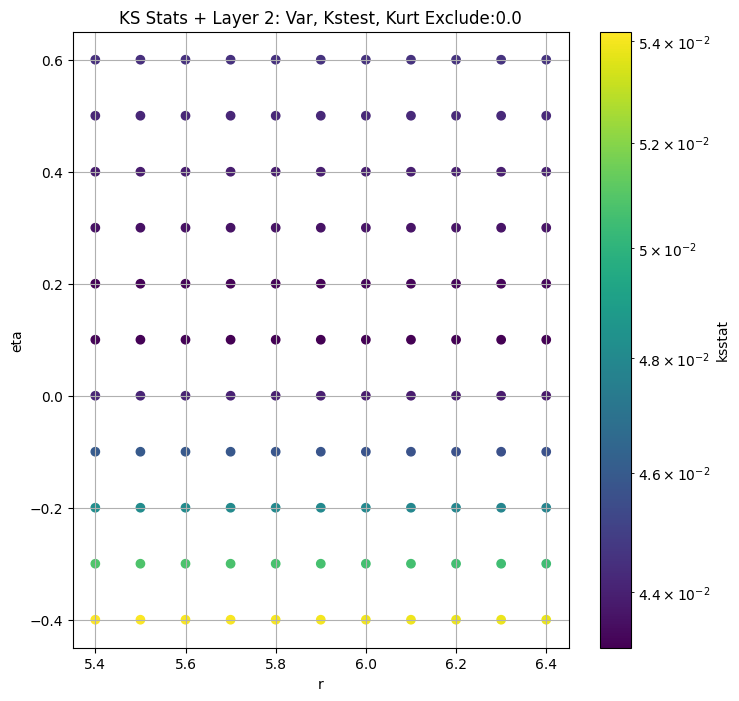

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.0347074888303151 3922.8953


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.03470439603566339 3821.1438


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.0347306427825802 3746.2478


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.034723043064089965 3679.5854


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.03472174326513344 3617.8552


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.03471558003825026 3505.4001


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.034711428262999056 3402.385


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.03475162093494327 3307.584


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.034747388346014874 3219.7979


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.03474543003547942 3138.2437


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.03480087084603778 2920.077
Number of samples: 28288, Without approximation : 28288


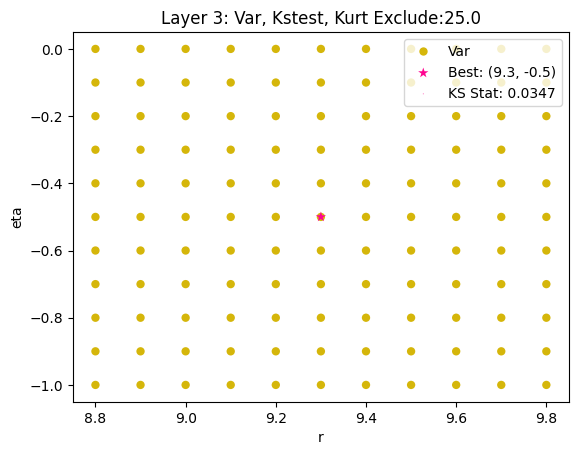

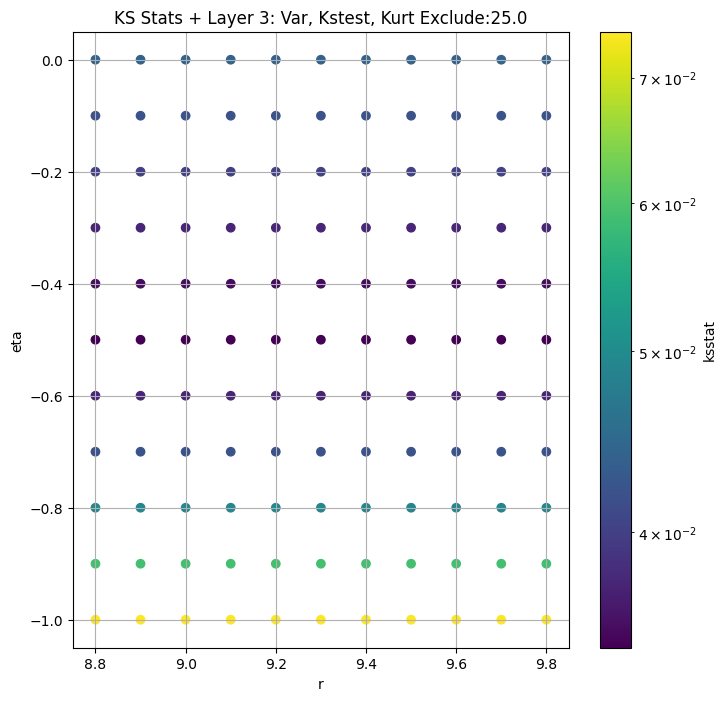

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.02764096950835071 930.99817


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.027646750272858955 916.7602


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.027634026013432622 906.733


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.027649273095127158 897.994


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.027651184905284232 890.03894


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.02762867134853103 875.5762


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.027620413940022626 862.47327


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.02763362164957489 850.41833


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.027627657991742716 839.2749


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.027684719104795696 828.81573


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.02765436478412675 800.40186
Number of samples: 100000, Without approximation : 113152


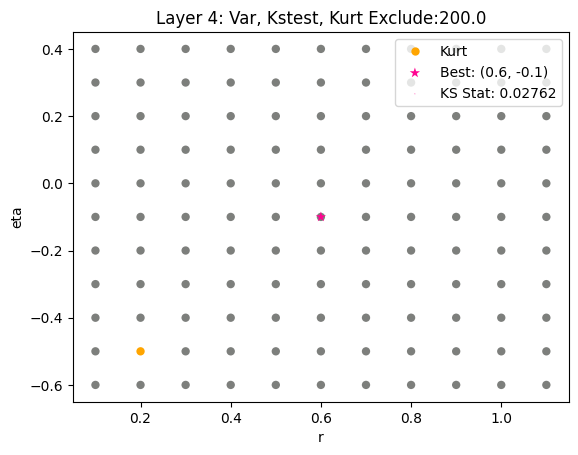

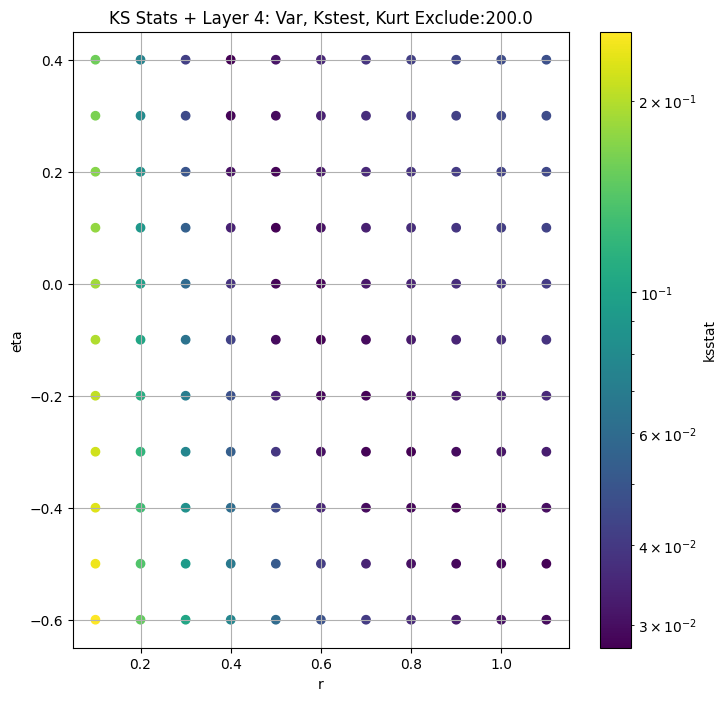

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.017180161696519924 218.6037


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.017299833604712544 214.23816


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.017026302129152515 211.48215


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.016811540066140718 209.06058


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.0166816074727823 206.86485


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.016584387208324447 202.92464


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.016693339079098368 199.39023


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.01657472884422645 196.13837


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.01678684525996632 193.12132


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.01692266831205319 190.30731


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.016724022784416426 182.73705
Number of samples: 100000, Without approximation : 452608


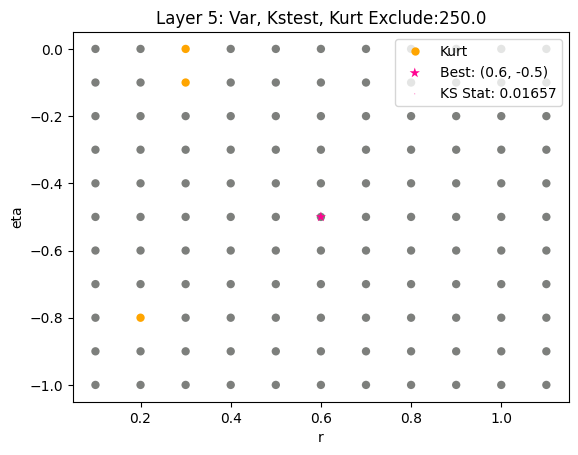

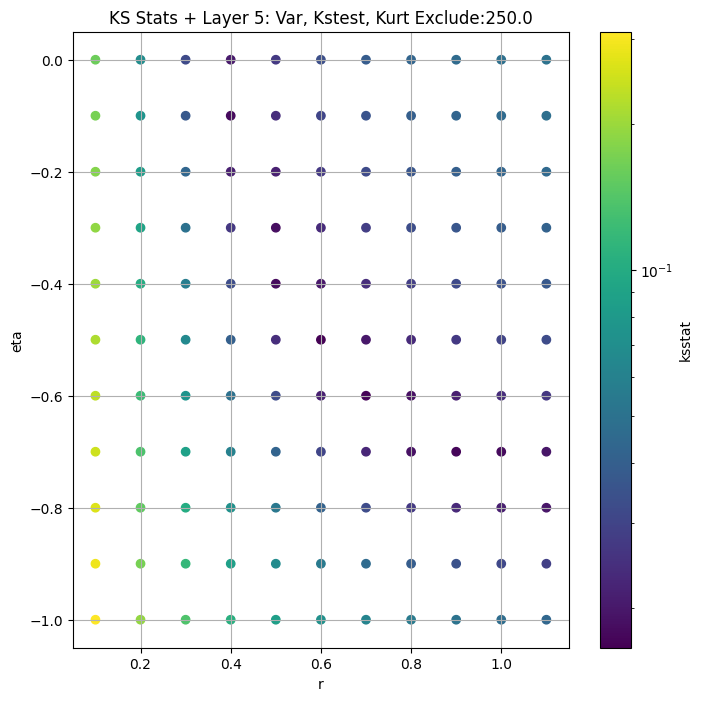

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.009396429415263086 49.85452


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.009616239160565532 48.704544


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.009796674070105316 47.98035


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.009877892000840938 47.36022


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.009524204105701928 46.79878


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.009652531312833723 45.79777


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.009313344091191833 44.903885


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.009251388858596221 44.085594


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.009378157221580974 43.327282


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.010297351943790778 42.61785


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.010418950245575265 40.711918
Number of samples: 100000, Without approximation : 1810432


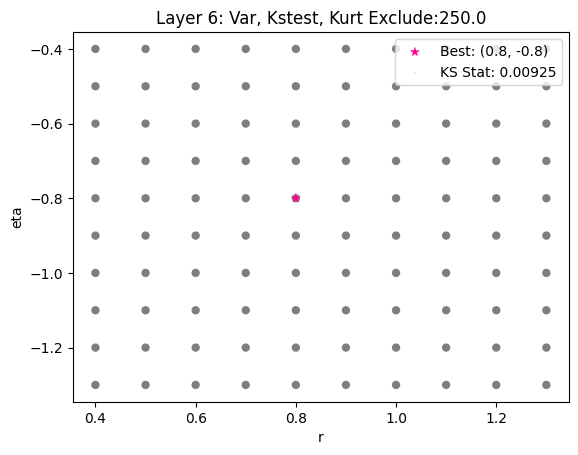

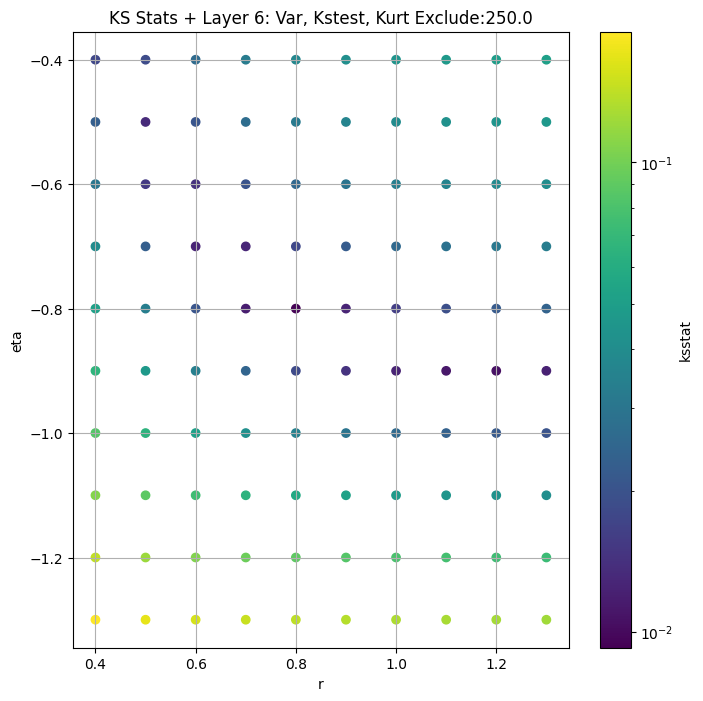

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.007362532461065108 11.294209


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.005926154624432245 10.991048


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.005251155158512266 10.807969


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.005385524893878779 10.651251


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.005987861920693116 10.510456


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.0075300990574174165 10.259711


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.0076080832377567464 10.037433


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.0077135524950631765 9.8353815


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.007608590452709674 9.64896


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.00781801866360965 9.475189


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.009044940491261082 9.01071
Number of samples: 100000, Without approximation : 7241728


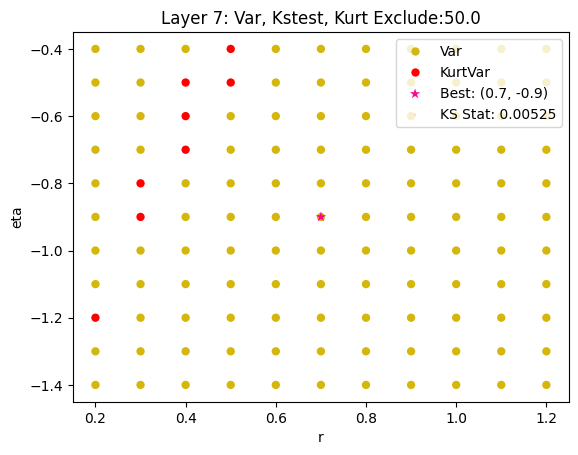

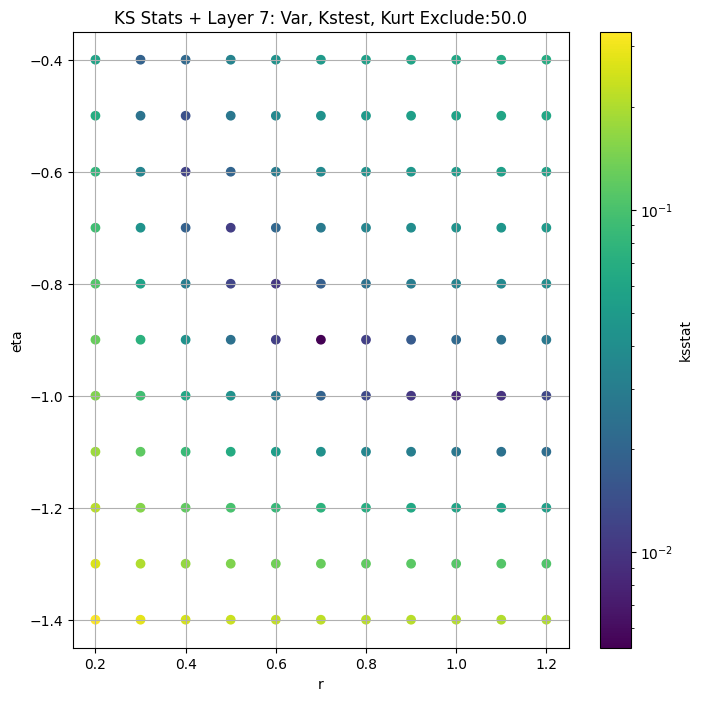

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.005753371589757861 2.5909934


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.006225092303873692 2.5058882


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.006508958554221067 2.4594


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.0067663109697864154 2.4199162


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.00635530247564825 2.3845015


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.005444681869539884 2.3217955


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.006540581366181485 2.266533


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.007618297110065481 2.2165163


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.00747974694827374 2.1705046


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.008372812175128377 2.1277149


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.00998090391943146 2.0138733
Number of samples: 100000, Without approximation : 28966912


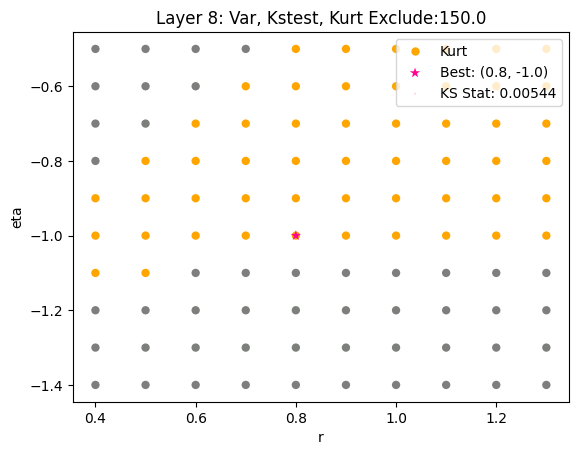

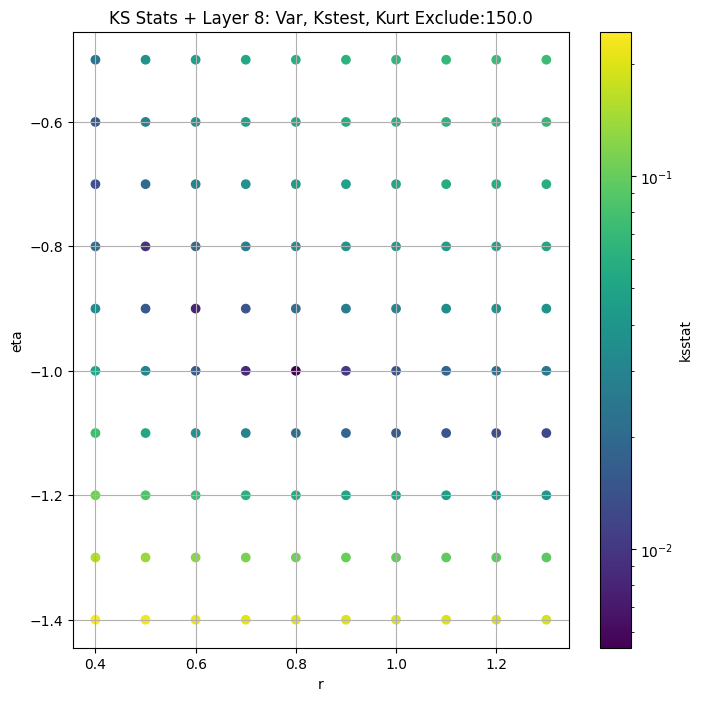

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.009228454292726285 0.6165116


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.006810435050691566 0.5925885


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.006017326476258189 0.5802461


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.0063077923310528305 0.56978333


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.006579858199664446 0.5604531


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.007777356914066003 0.54401964


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.00925207693244312 0.52961403


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.008364077693277128 0.5166472


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.008506350388412964 0.50477433


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.009545008372031094 0.49377945


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.010308980558522585 0.46475616
Number of samples: 100000, Without approximation : 115867648


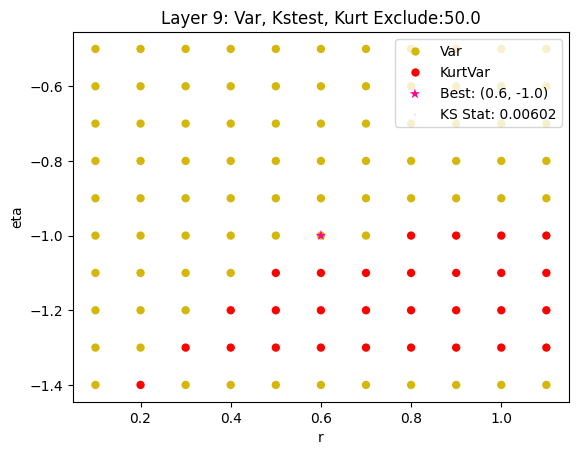

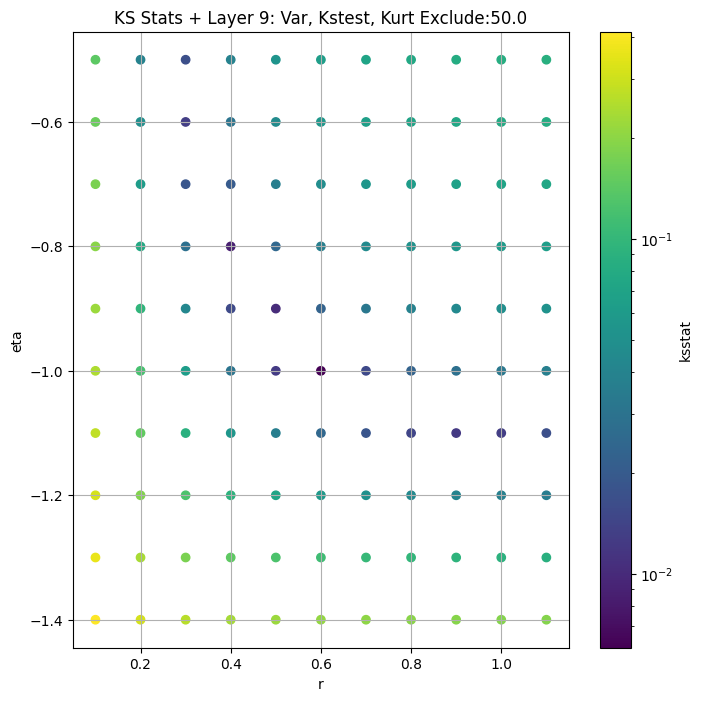

####
Layer  10


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 0 0.005015968210843269 0.14887652


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 25 0.007614494086332968 0.14164111


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 50 0.0061091725684634945 0.13808778


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 75 0.006877997955271997 0.13511214


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 100 0.006739547552259306 0.13248205


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 150 0.006698729842368523 0.12789789


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 200 0.006963586322971171 0.12392858


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 250 0.00735118129831696 0.1203909


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 300 0.008321661622766076 0.11718143


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 350 0.008801962023695736 0.11423433


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 500 0.009849210052876714 0.10656453
Number of samples: 100000, Without approximation : 463470592


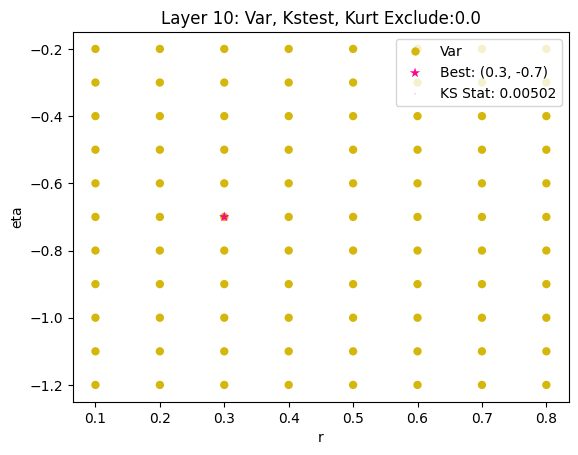

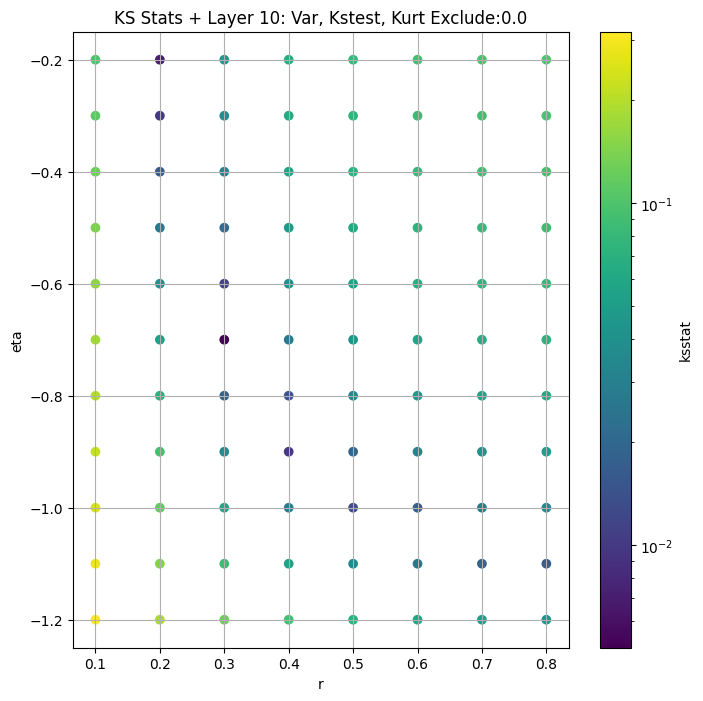

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      16354.510000  15633.312000  17082.553000   0.101962   -0.016666   
3       3922.895300   3744.966800   4103.727000   1.139715    0.928585   
4        930.998170    880.450900    983.070430   2.526734    2.019438   
5        218.603700    205.369100    232.632840   3.912470    2.933228   
6         49.854520     46.540530     53.384290   5.029304    3.773884   
7         11.294209     10.485279     12.181979   6.461322    4.597968   
8          2.590993      2.385578      2.849584   9.492075    5.469928   
9          0.616512      0.562501      0.693044  13.534157    6.594753   
10         0.148877      0.133936      0.172039  20.531488    8.519738   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.226260           7072             0.043105        5.9          0.1   
3        1.379318          28288             0.034704        9.3         -0.5   
4        3.304371         113152             0.027620        0.6         -0.1   
5        7.310871         452608             0.016575        0.6         -0.5   
6        9.386376        1810432             0.009251        0.8         -0.8   
7       13.692297        7241728             0.005251        0.7         -0.9   
8       34.075478       28966912             0.005445        0.8         -1.0   
9       54.788080      115867648             0.006017        0.6         -1.0   
10      90.276040      463470592             0.005016        0.3         -0.7   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       27070.913566                     0.0        16354.510000   
3        7926.867310                    25.0         3821.143800   
4         171.149101                   200.0          862.473270   
5          63.733941                   250.0          196.138370   
6          45.341917                   250.0           44.085594   
7          10.331010                    50.0           10.807969   
8           3.493286                   150.0            2.321795   
9           0.492706                    50.0            0.580246   
10          0.001867                     0.0            0.148877   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.016126  
3                     0.008069  
4                     0.004036  
5                     0.002018  
6                     0.001009  
7                     0.000505  
8                     0.000252  
9                     0.000126  
10                    0.000063

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/117 [00:00<?, ?it/s]

Finding Minimum after computing 117 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.048614154102097906, var: 13710.951171875


  0%|          | 0/117 [00:00<?, ?it/s]

Finding Minimum after computing 117 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.04545752993598484, var: 14249.37890625


  0%|          | 0/117 [00:00<?, ?it/s]

Finding Minimum after computing 117 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.04324997270957742, var: 14835.1875


  0%|          | 0/117 [00:00<?, ?it/s]

Finding Minimum after computing 117 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.04310644376122874, var: 15489.5771484375


  0%|          | 0/117 [00:00<?, ?it/s]

Finding Minimum after computing 117 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.043105258558855386, var: 16354.509765625
Number of samples: 7072, Without approximation : 7072


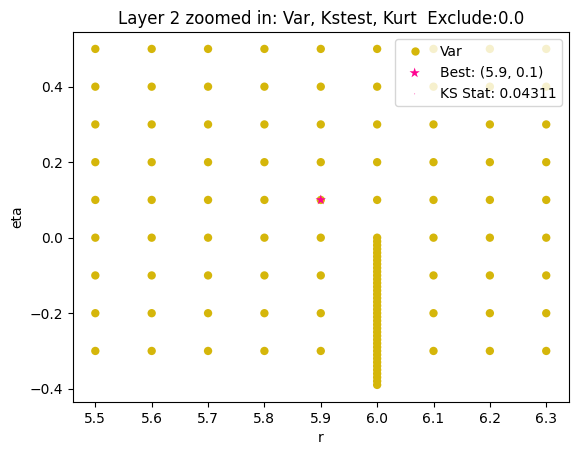

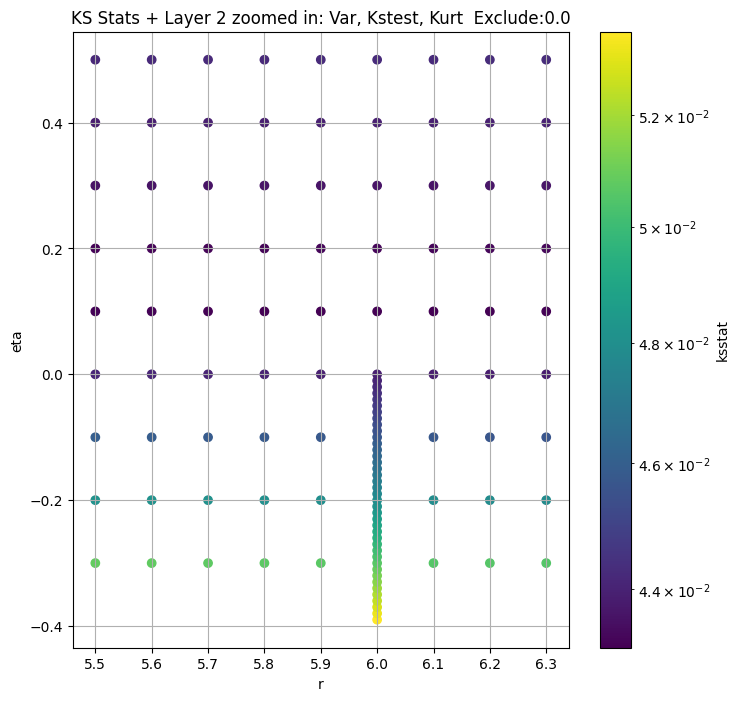

Layer 3


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 3, 25.0 + 100 = 125, ksstat: 0.03472344328147653, var: 3560.099365234375


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 3, 25.0 + 75 = 100, ksstat: 0.03474663155115104, var: 3617.855224609375


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 3, 25.0 + 50 = 75, ksstat: 0.03470666930208899, var: 3679.58544921875


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 3, 25.0 + 25 = 50, ksstat: 0.03474171842291213, var: 3746.247802734375


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 3, 25.0 + 0 = 25, ksstat: 0.03470439603566339, var: 3821.143798828125


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 3, 25.0 + -25 = 0, ksstat: 0.034717811088719464, var: 3922.895263671875
Number of samples: 28288, Without approximation : 28288


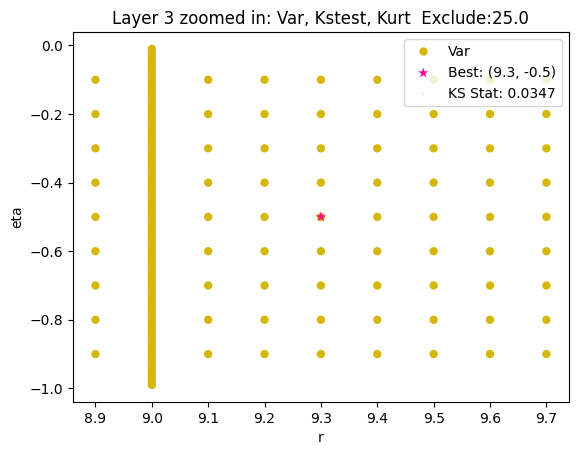

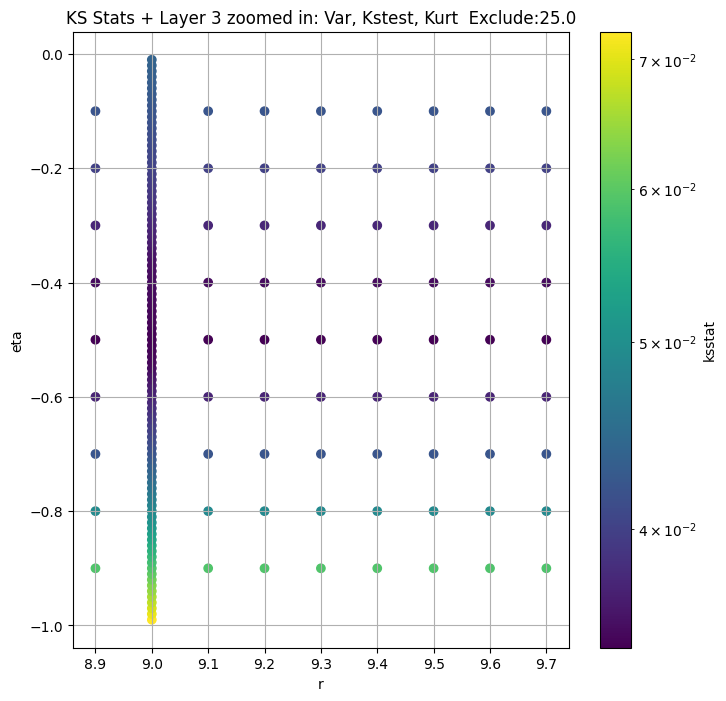

Layer 4


  0%|          | 0/1377 [00:00<?, ?it/s]

Finding Minimum after computing 1377 CDFs
layer 4, 200.0 + 100 = 300, ksstat: 0.027624768238307007, var: 839.27490234375


  0%|          | 0/1377 [00:00<?, ?it/s]

Finding Minimum after computing 1377 CDFs
layer 4, 200.0 + 75 = 275, ksstat: 0.027621378799936147, var: 844.7384643554688


  0%|          | 0/1377 [00:00<?, ?it/s]

Finding Minimum after computing 1377 CDFs
layer 4, 200.0 + 50 = 250, ksstat: 0.027616049290407785, var: 850.4183349609375


  0%|          | 0/1377 [00:00<?, ?it/s]

Finding Minimum after computing 1377 CDFs
layer 4, 200.0 + 25 = 225, ksstat: 0.027619189170583924, var: 856.3184814453125


  0%|          | 0/1377 [00:00<?, ?it/s]

Finding Minimum after computing 1377 CDFs
layer 4, 200.0 + 0 = 200, ksstat: 0.027616589049667628, var: 862.4732666015625


  0%|          | 0/1377 [00:00<?, ?it/s]

Finding Minimum after computing 1377 CDFs
layer 4, 200.0 + -25 = 175, ksstat: 0.027625874266547223, var: 868.9022216796875


  0%|          | 0/1377 [00:00<?, ?it/s]

Finding Minimum after computing 1377 CDFs
layer 4, 200.0 + -50 = 150, ksstat: 0.027618659254996125, var: 875.576171875


  0%|          | 0/1377 [00:00<?, ?it/s]

Finding Minimum after computing 1377 CDFs
layer 4, 200.0 + -75 = 125, ksstat: 0.02762484374113089, var: 882.601806640625


  0%|          | 0/1377 [00:00<?, ?it/s]

Finding Minimum after computing 1377 CDFs
layer 4, 200.0 + -100 = 100, ksstat: 0.02762131844080934, var: 890.0389404296875
Number of samples: 100000, Without approximation : 113152


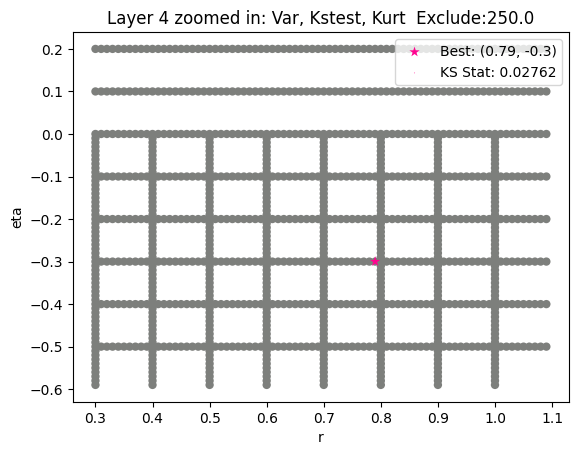

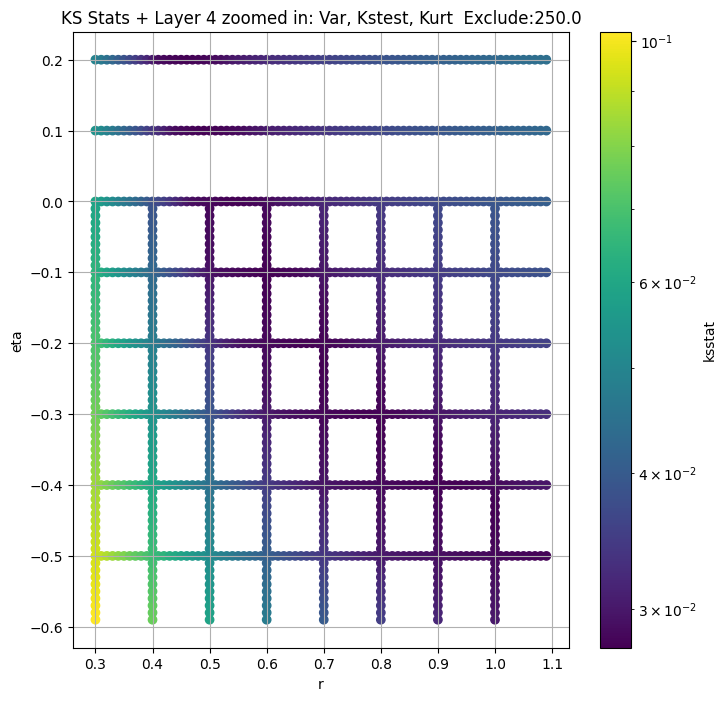

Layer 5


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 250.0 + 100 = 350, ksstat: 0.016522384860774453, var: 190.30731201171875


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 250.0 + 75 = 325, ksstat: 0.016574852398463513, var: 191.69143676757812


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 250.0 + 50 = 300, ksstat: 0.01655004893052231, var: 193.12132263183594


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 250.0 + 25 = 275, ksstat: 0.016541943082491573, var: 194.60133361816406


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 250.0 + 0 = 250, ksstat: 0.01657472884422645, var: 196.13836669921875


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 250.0 + -25 = 225, ksstat: 0.016539178252041598, var: 197.7335205078125


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 250.0 + -50 = 200, ksstat: 0.01653624188806202, var: 199.39022827148438


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 250.0 + -75 = 175, ksstat: 0.016528904144599565, var: 201.1173095703125


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 250.0 + -100 = 150, ksstat: 0.016584387208324447, var: 202.9246368408203
Number of samples: 100000, Without approximation : 452608


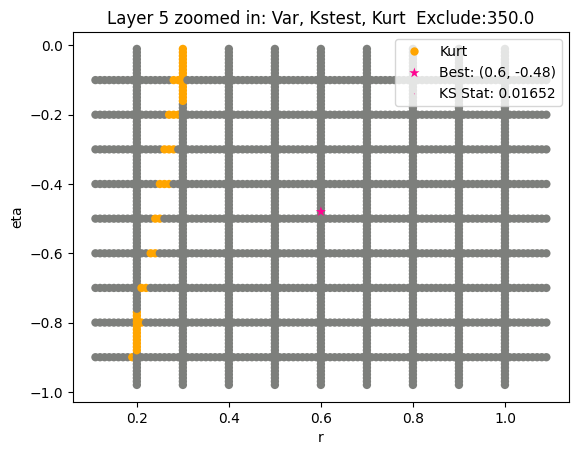

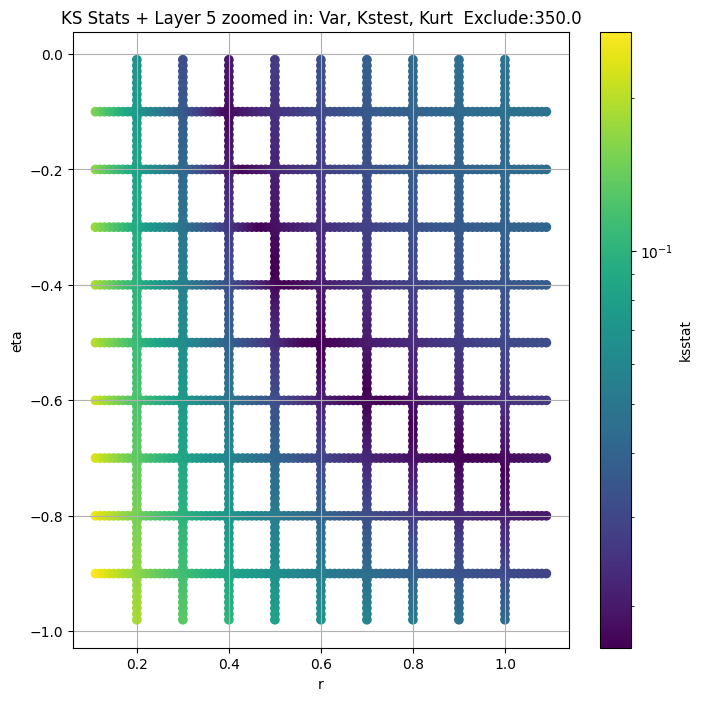

Layer 6


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + 100 = 350, ksstat: 0.009319123341538837, var: 42.61785125732422


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + 75 = 325, ksstat: 0.009209593430525603, var: 42.96683120727539


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + 50 = 300, ksstat: 0.00913364189909617, var: 43.3272819519043


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + 25 = 275, ksstat: 0.009143376843917195, var: 43.69985580444336


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + 0 = 250, ksstat: 0.009165210435169269, var: 44.085594177246094


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + -25 = 225, ksstat: 0.009187491296991923, var: 44.4865837097168


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + -50 = 200, ksstat: 0.00900053352663377, var: 44.90388488769531


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + -75 = 175, ksstat: 0.009023100247936289, var: 45.339874267578125


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 6, 250.0 + -100 = 150, ksstat: 0.009130375725101558, var: 45.79777145385742
Number of samples: 100000, Without approximation : 1810432


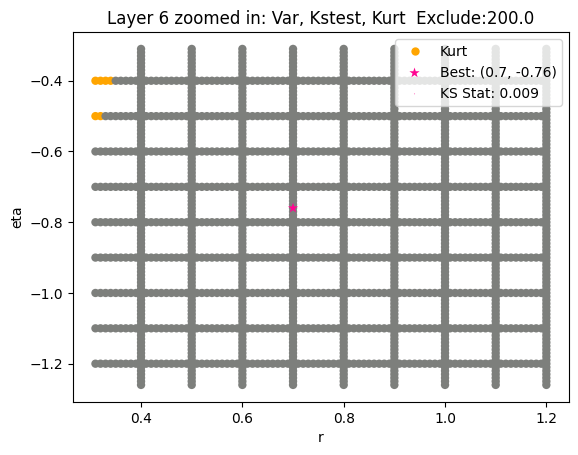

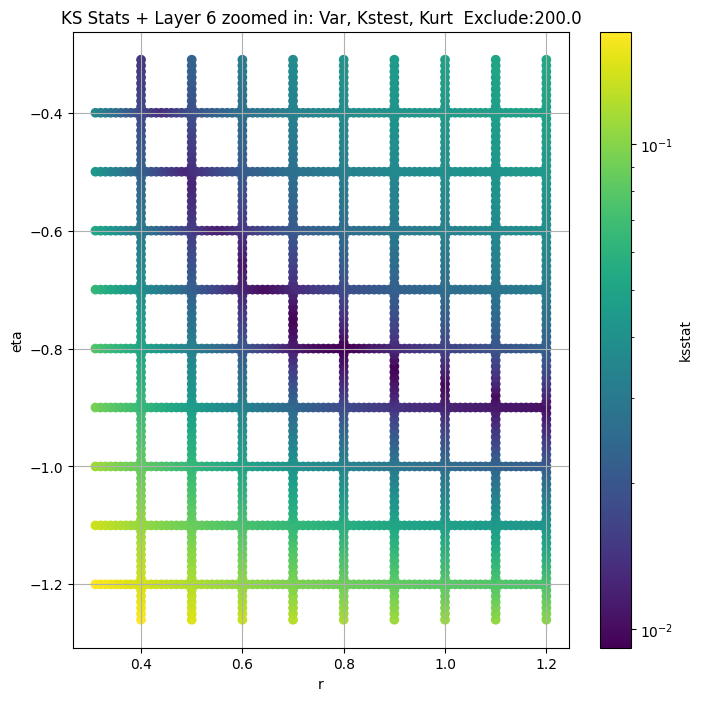

Layer 7


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 7, 50.0 + 100 = 150, ksstat: 0.005883189492583124, var: 10.259711265563965


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 7, 50.0 + 75 = 125, ksstat: 0.005855705359599131, var: 10.380789756774902


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 7, 50.0 + 50 = 100, ksstat: 0.005558865728700721, var: 10.510456085205078


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 7, 50.0 + 25 = 75, ksstat: 0.005226469687728552, var: 10.651250839233398


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 7, 50.0 + 0 = 50, ksstat: 0.005251155158512266, var: 10.807969093322754


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 7, 50.0 + -25 = 25, ksstat: 0.005262774350525912, var: 10.991047859191895


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
layer 7, 50.0 + -50 = 0, ksstat: 0.004874350862909271, var: 11.294208526611328
Number of samples: 100000, Without approximation : 7241728


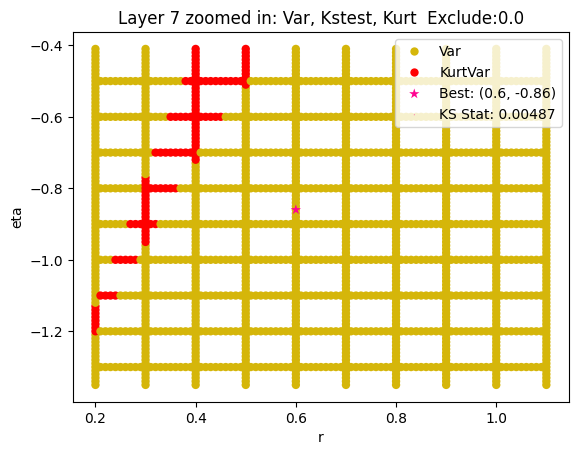

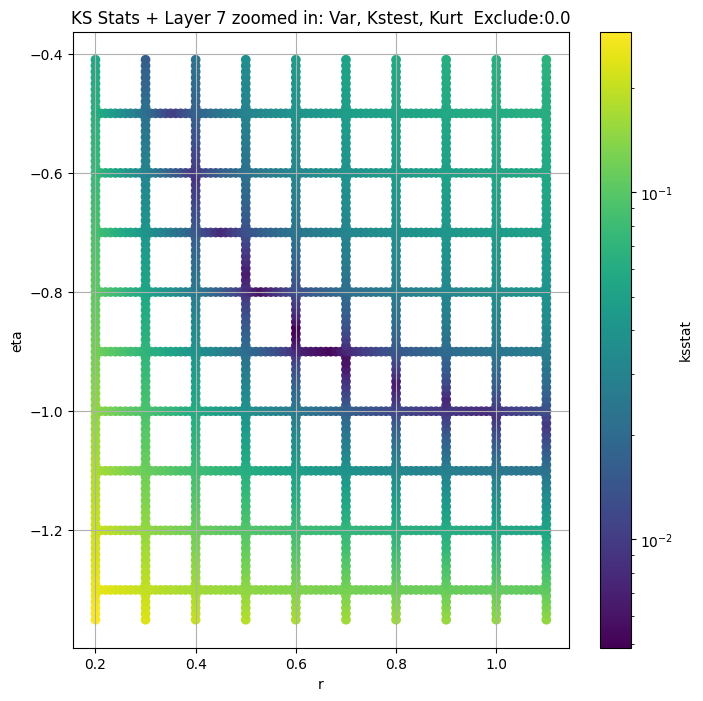

Layer 8


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 8, 150.0 + 100 = 250, ksstat: 0.006348482339218919, var: 2.2165162563323975


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 8, 150.0 + 75 = 225, ksstat: 0.006243500531263477, var: 2.2409608364105225


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 8, 150.0 + 50 = 200, ksstat: 0.005822530585201546, var: 2.2665328979492188


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 8, 150.0 + 25 = 175, ksstat: 0.0057712196797541845, var: 2.293405532836914


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 8, 150.0 + 0 = 150, ksstat: 0.005425363530567662, var: 2.3217954635620117


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 8, 150.0 + -25 = 125, ksstat: 0.005069354881962362, var: 2.3520121574401855


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 8, 150.0 + -50 = 100, ksstat: 0.0050824076877397095, var: 2.3845014572143555


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 8, 150.0 + -75 = 75, ksstat: 0.004752602505939139, var: 2.4199161529541016


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 8, 150.0 + -100 = 50, ksstat: 0.004683661944488049, var: 2.459399938583374
Number of samples: 100000, Without approximation : 28966912


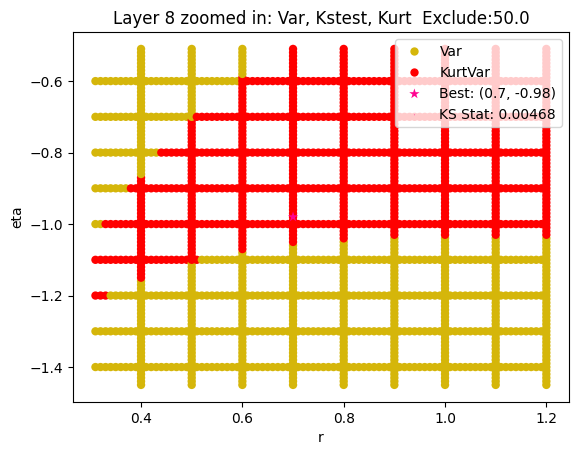

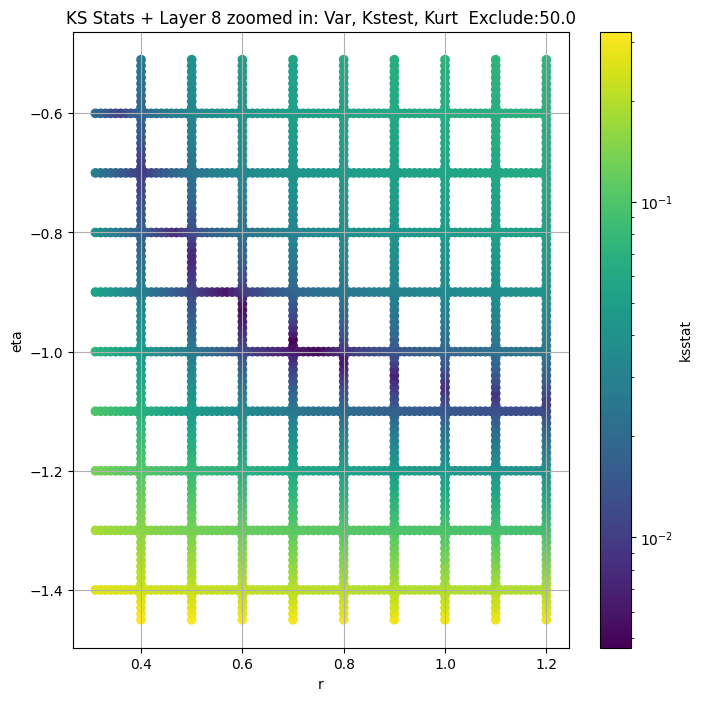

Layer 9


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 9, 50.0 + 100 = 150, ksstat: 0.006362374364493273, var: 0.5440196394920349


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 9, 50.0 + 75 = 125, ksstat: 0.005952684448315204, var: 0.5519270300865173


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 9, 50.0 + 50 = 100, ksstat: 0.005770443328434016, var: 0.5604531168937683


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 9, 50.0 + 25 = 75, ksstat: 0.00589866383507065, var: 0.5697833299636841


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 9, 50.0 + 0 = 50, ksstat: 0.006017326476258189, var: 0.580246090888977


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 9, 50.0 + -25 = 25, ksstat: 0.005855881028588805, var: 0.592588484287262


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 9, 50.0 + -50 = 0, ksstat: 0.005017260750940777, var: 0.6165115833282471
Number of samples: 100000, Without approximation : 115867648


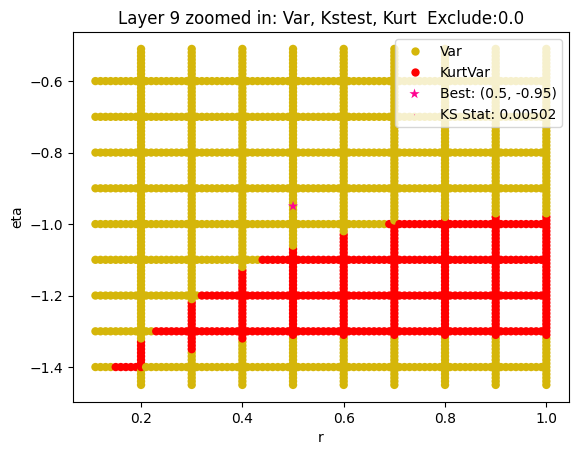

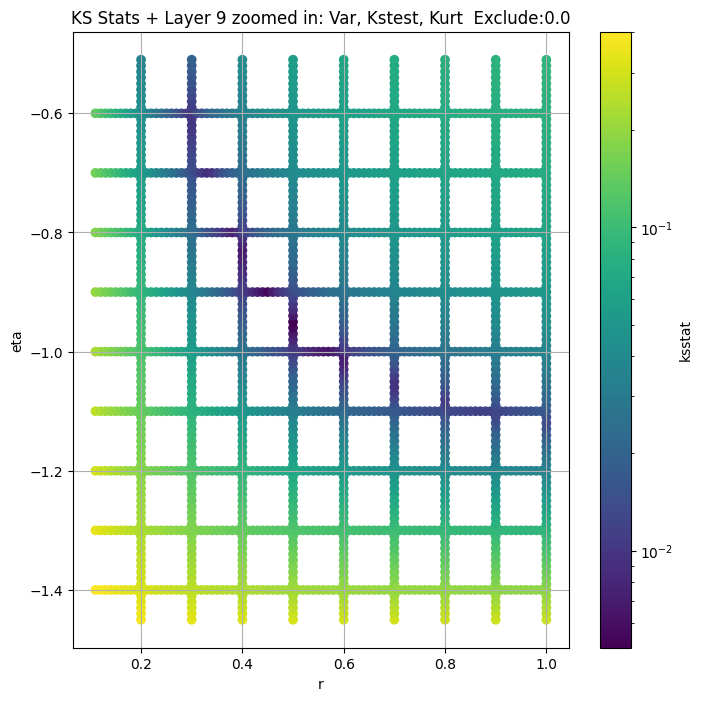

Layer 10


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 10, 0.0 + 100 = 100, ksstat: 0.00551076332310254, var: 0.13248205184936523


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 10, 0.0 + 75 = 75, ksstat: 0.005038218610607971, var: 0.13511213660240173


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 10, 0.0 + 50 = 50, ksstat: 0.004431405305099778, var: 0.13808777928352356


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 10, 0.0 + 25 = 25, ksstat: 0.004154441059052327, var: 0.14164111018180847


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 10, 0.0 + 0 = 0, ksstat: 0.003946255482238814, var: 0.14887651801109314
Number of samples: 100000, Without approximation : 463470592


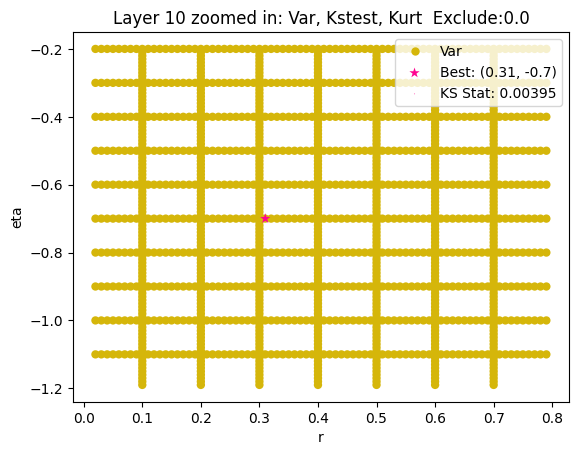

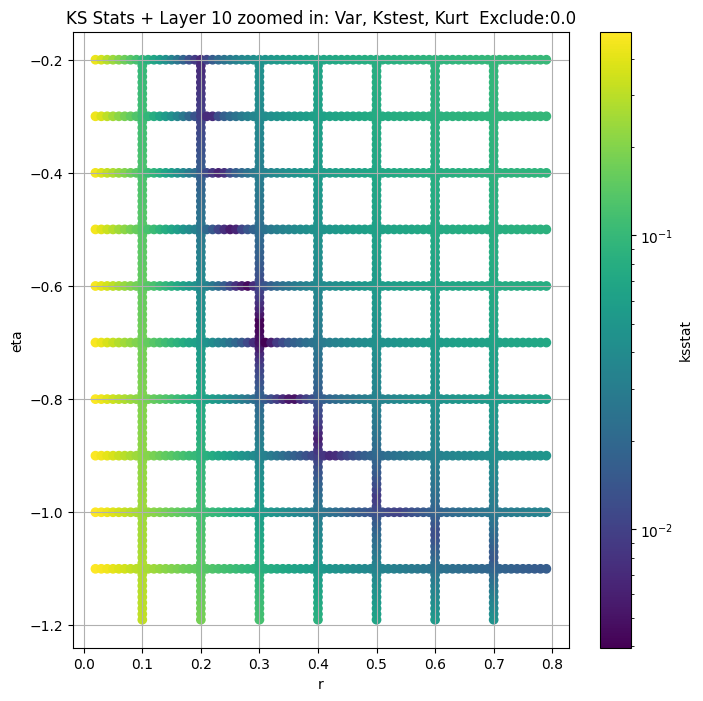

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      16354.510000  15633.312000  17082.553000   0.101962   -0.016666   
3       3922.895300   3744.966800   4103.727000   1.139715    0.928585   
4        930.998170    880.450900    983.070430   2.526734    2.019438   
5        218.603700    205.369100    232.632840   3.912470    2.933228   
6         49.854520     46.540530     53.384290   5.029304    3.773884   
7         11.294209     10.485279     12.181979   6.461322    4.597968   
8          2.590993      2.385578      2.849584   9.492075    5.469928   
9          0.616512      0.562501      0.693044  13.534157    6.594753   
10         0.148877      0.133936      0.172039  20.531488    8.519738   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.226260           7072             0.043105        5.9          0.1   
3        1.379318          28288             0.034704        9.3         -0.5   
4        3.304371         113152             0.027620        0.6         -0.1   
5        7.310871         452608             0.016575        0.6         -0.5   
6        9.386376        1810432             0.009251        0.8         -0.8   
7       13.692297        7241728             0.005251        0.7         -0.9   
8       34.075478       28966912             0.005445        0.8         -1.0   
9       54.788080      115867648             0.006017        0.6         -1.0   
10      90.276040      463470592             0.005016        0.3         -0.7   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       27070.913566                     0.0        16354.510000   
3        7926.867310                    25.0         3821.143800   
4         171.149101                   200.0          850.418335   
5          63.733941                   250.0          190.307312   
6          45.341917                   250.0           44.903885   
7          10.331010                    50.0           11.294209   
8           3.493286                   150.0            2.459400   
9           0.492706                    50.0            0.616512   
10          0.001867                     0.0            0.148877   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.016126          0.043105    5.90      0.10   
3                     0.008069          0.034704    9.30     -0.50   
4                     0.004036          0.027616    0.79     -0.30   
5                     0.002018          0.016522    0.60     -0.48   
6                     0.001009          0.009001    0.70     -0.76   
7                     0.000505          0.004874    0.60     -0.86   
8                     0.000252          0.004684    0.70     -0.98   
9                     0.000126          0.005017    0.50     -0.95   
10                    0.000063          0.003946    0.31     -0.70   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      27070.913566                  0.0          994  
3       7926.867310                 25.0         1491  
4        455.694239                250.0         2515  
5         60.097380                350.0         7072  
6         33.097781                200.0        23868  
7          6.873845                  0.0        80554  
8          2.799353                 50.0        84864  
9          0.266888                  0.0        71604  
10         0.002424                  0.0       113152

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

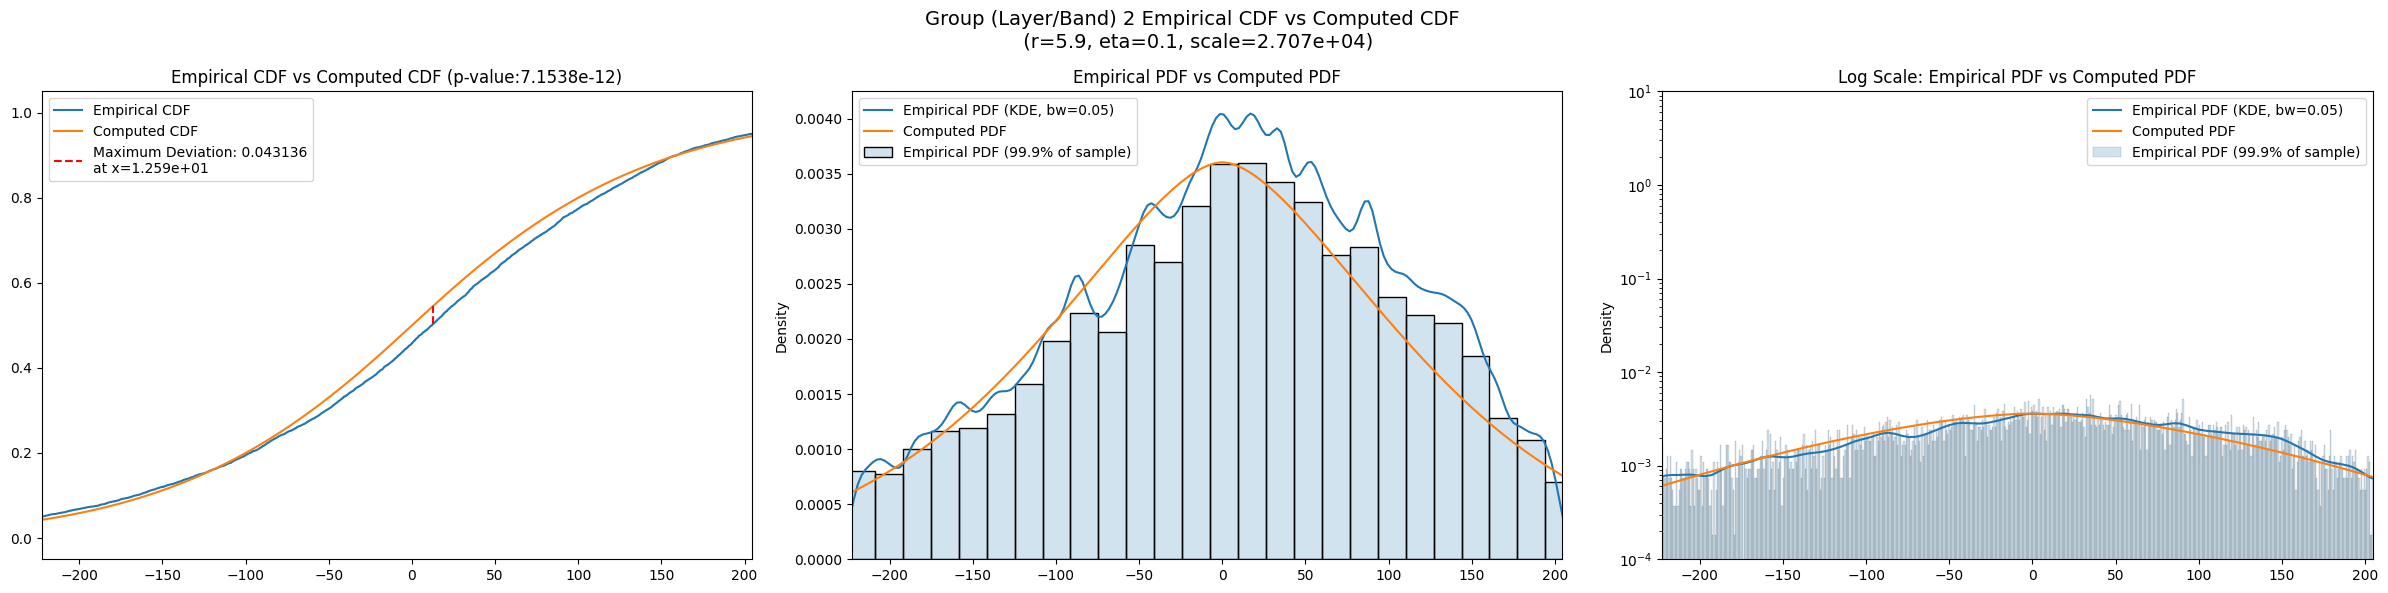

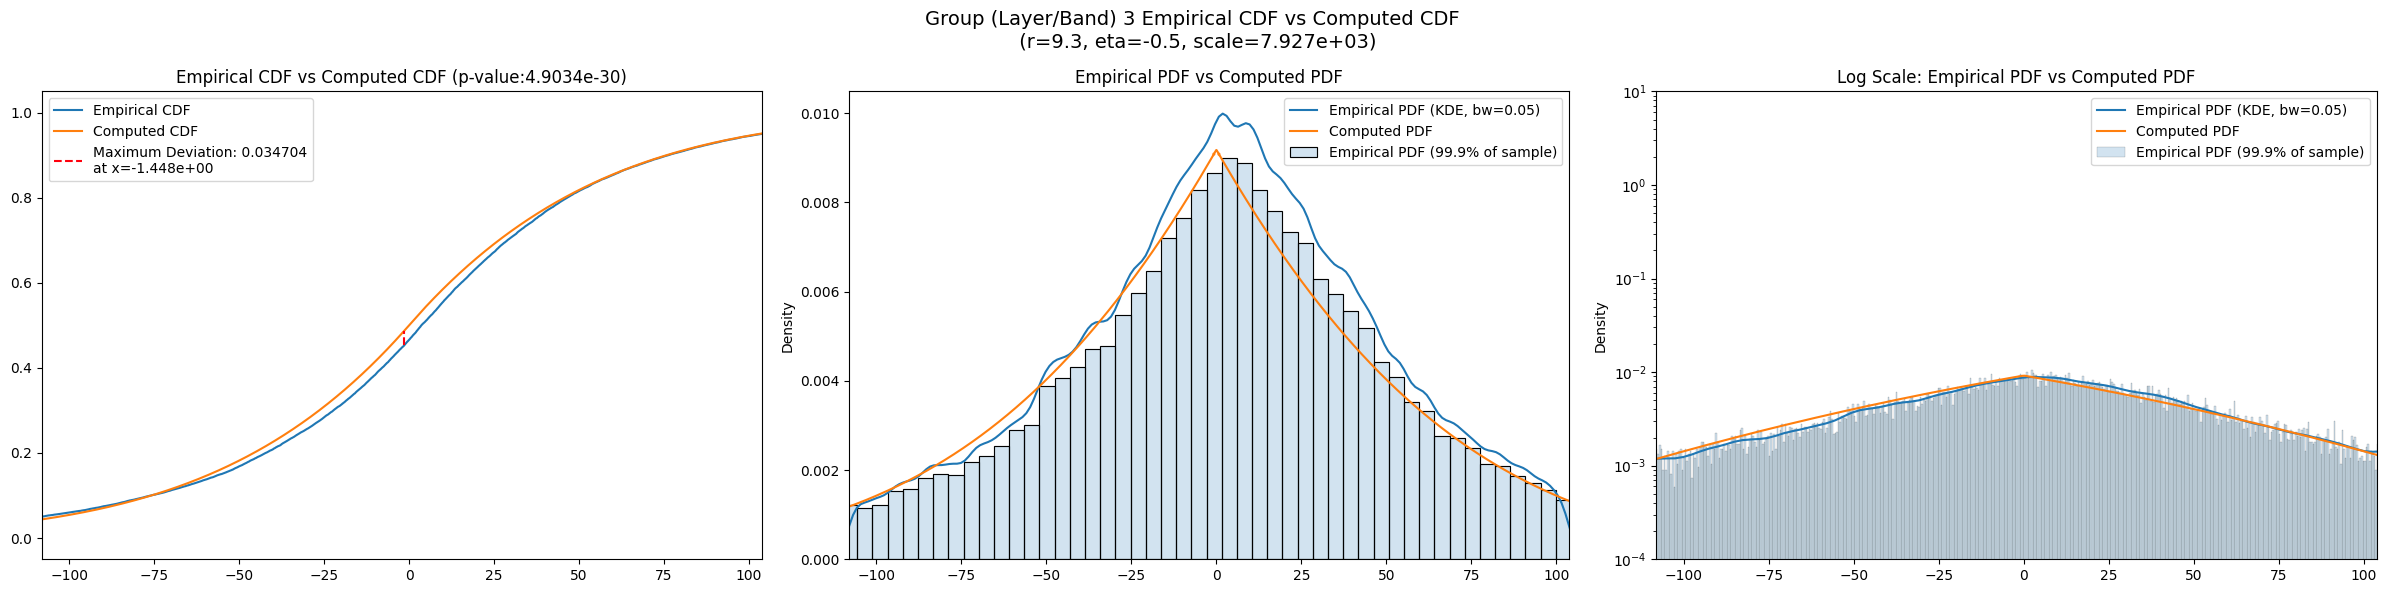

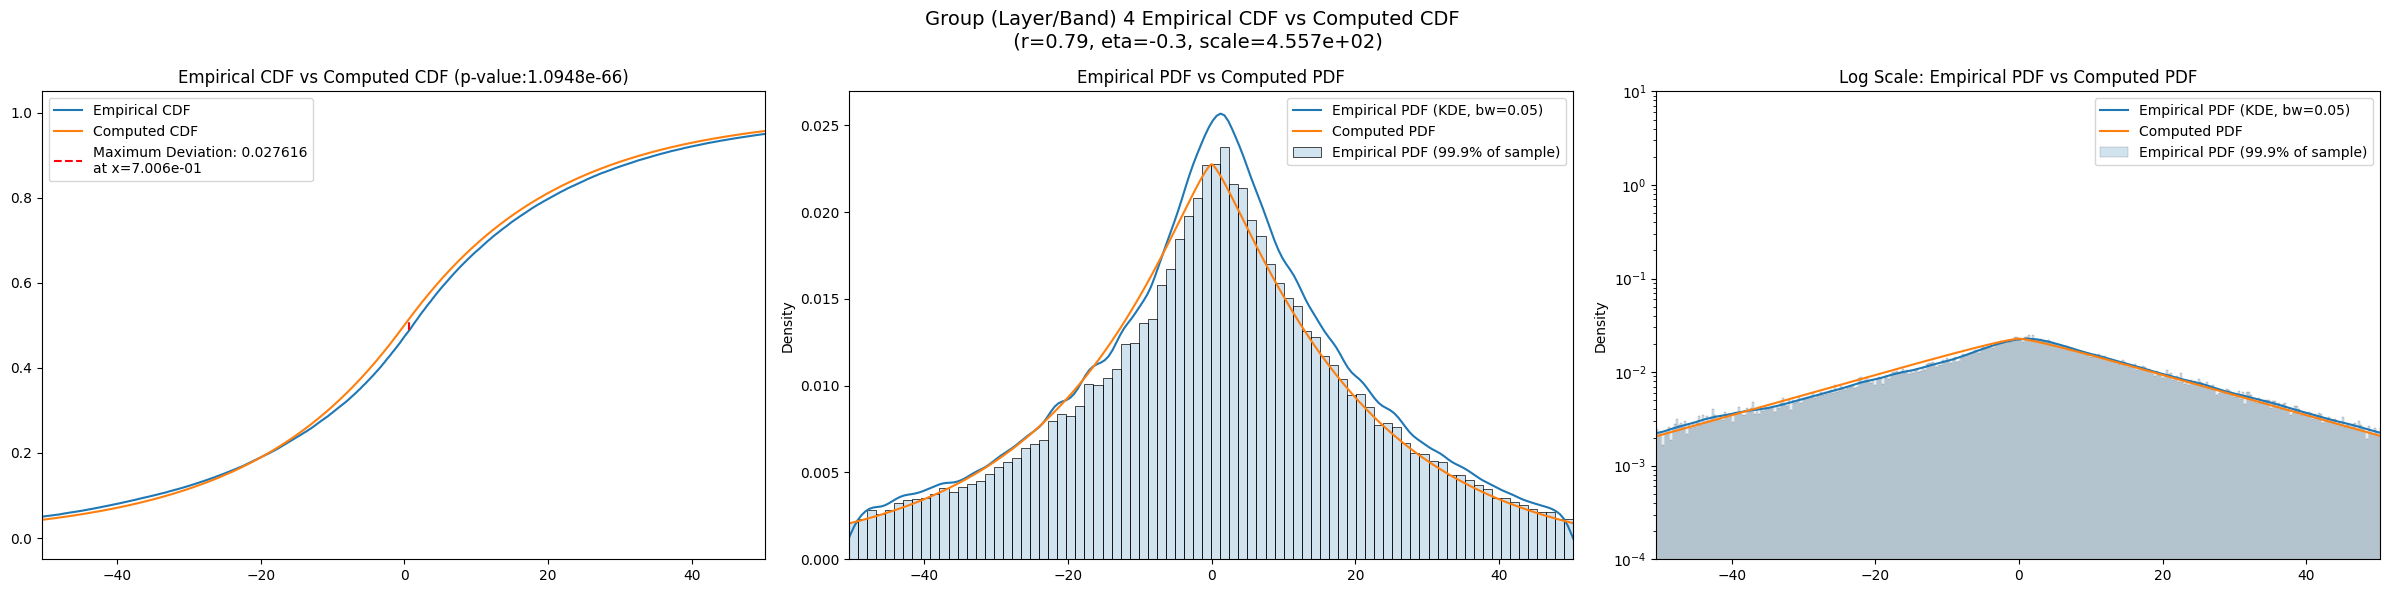

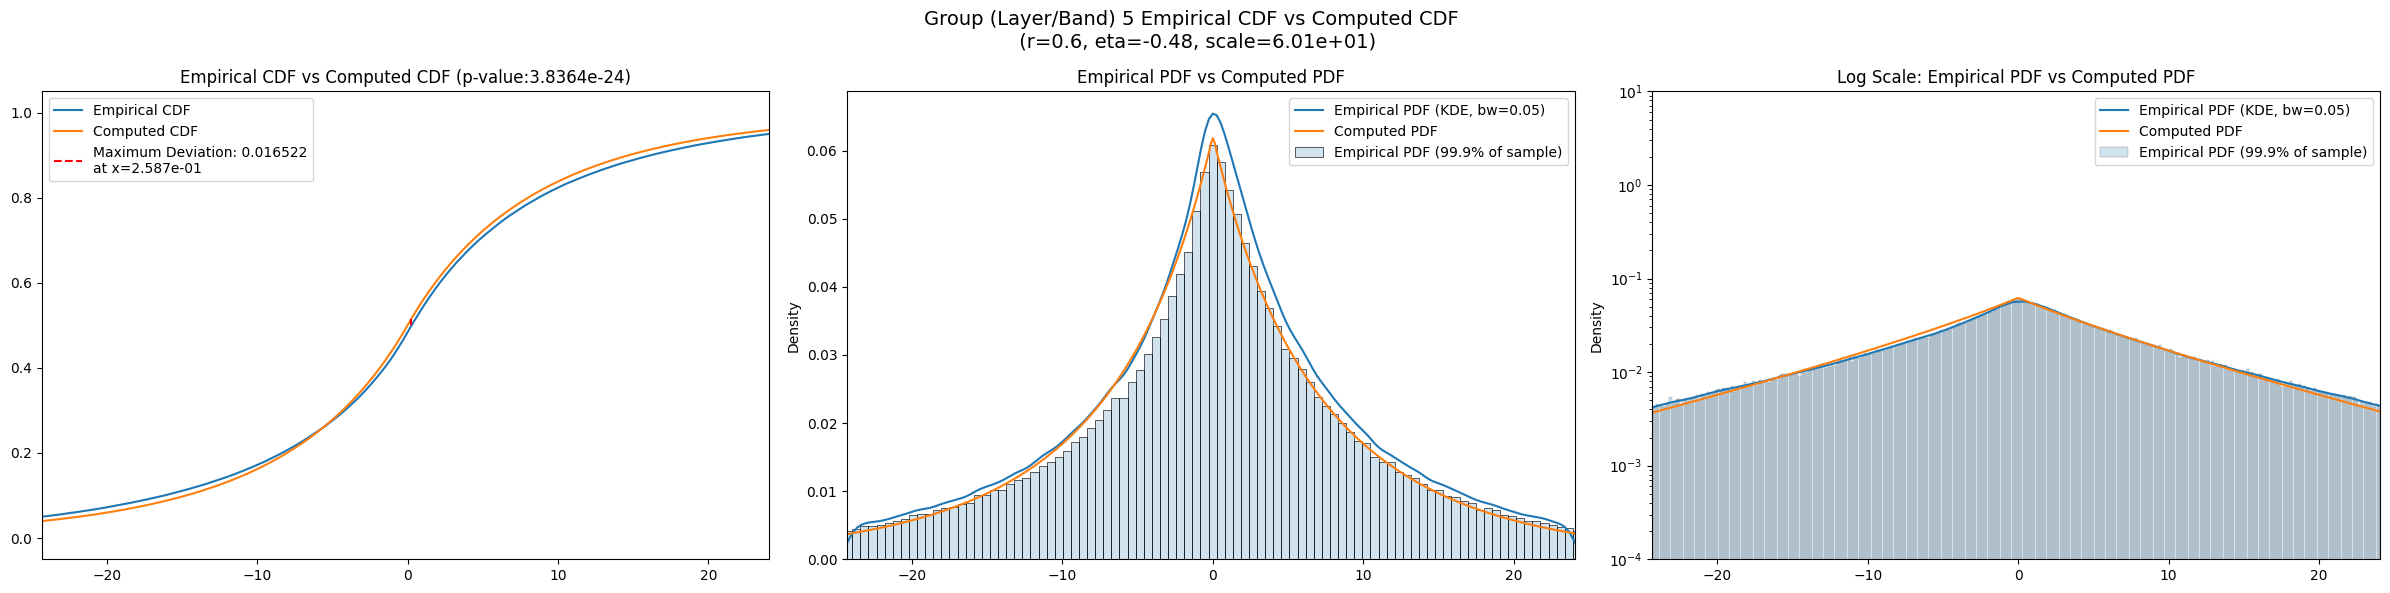

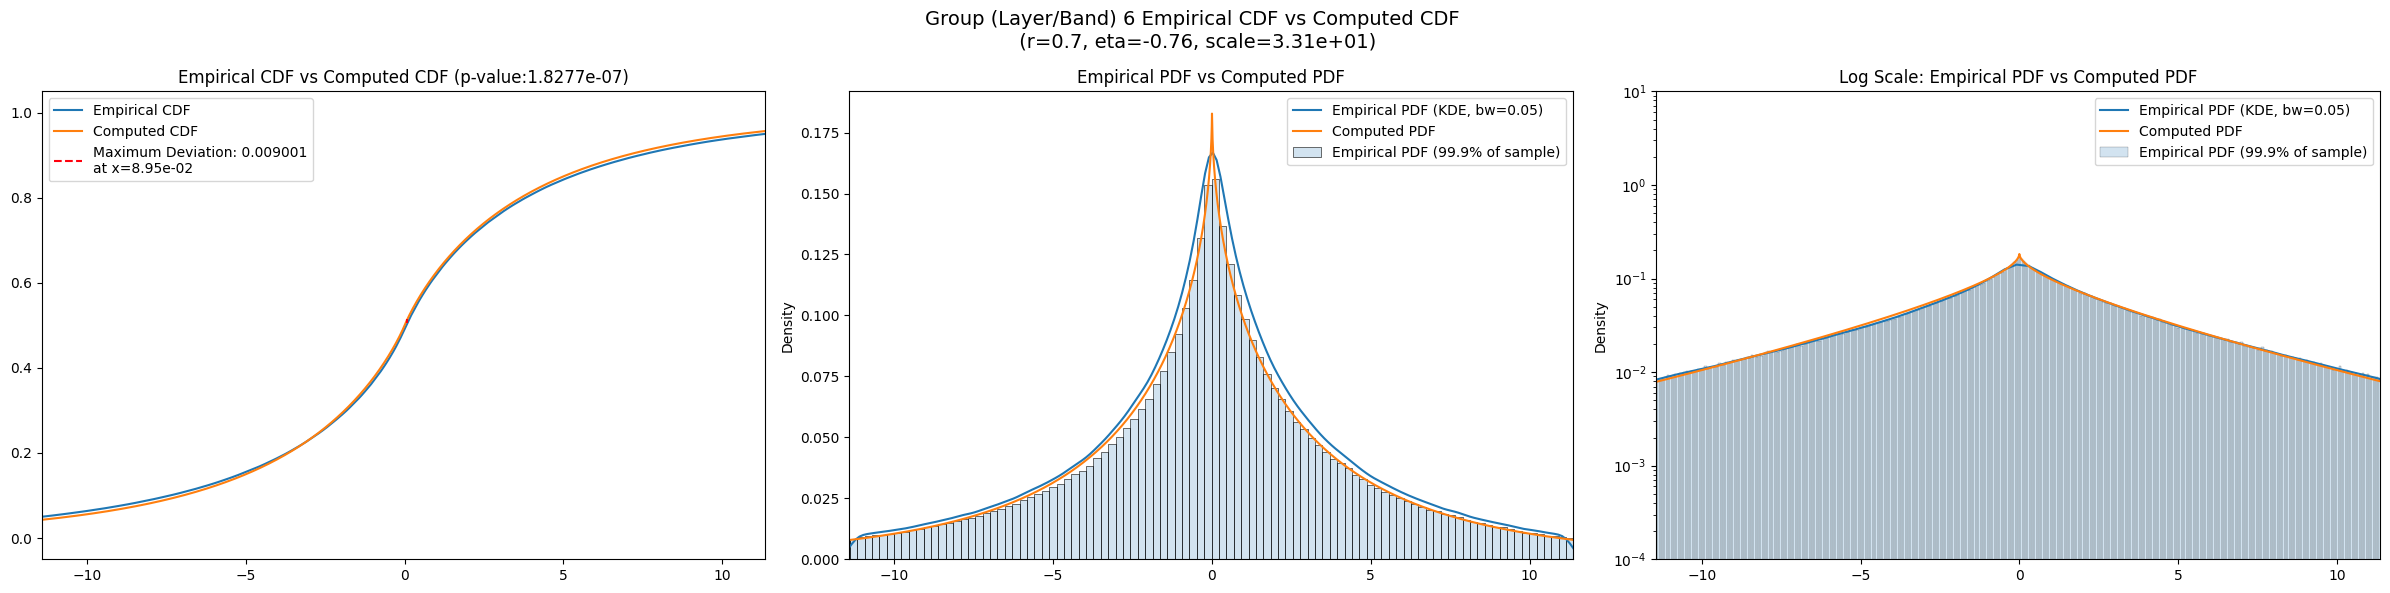

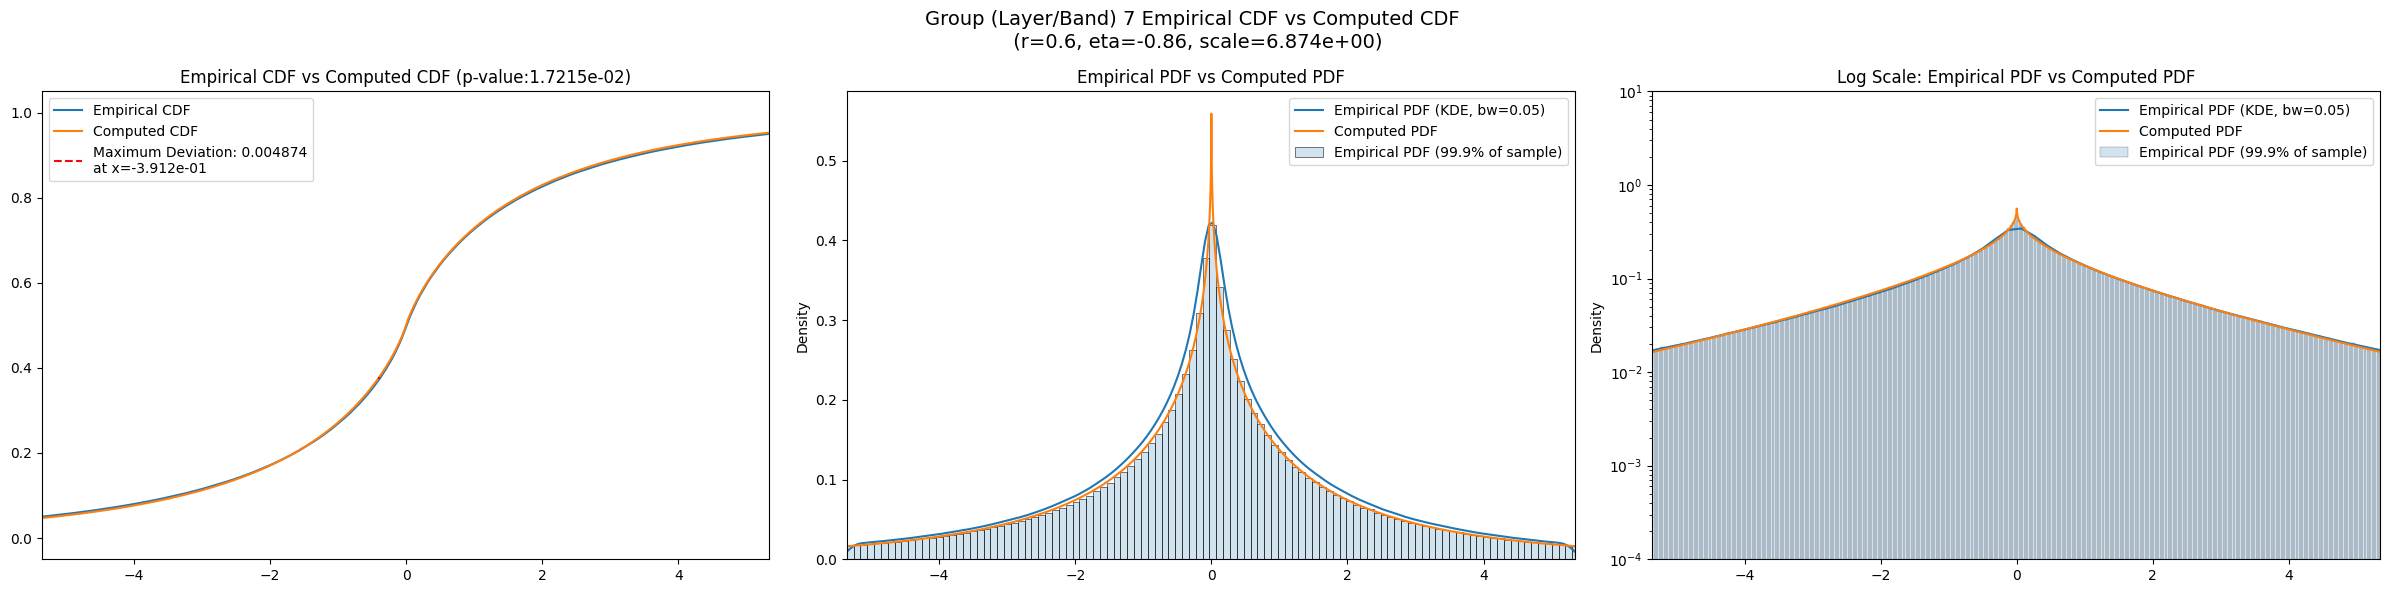

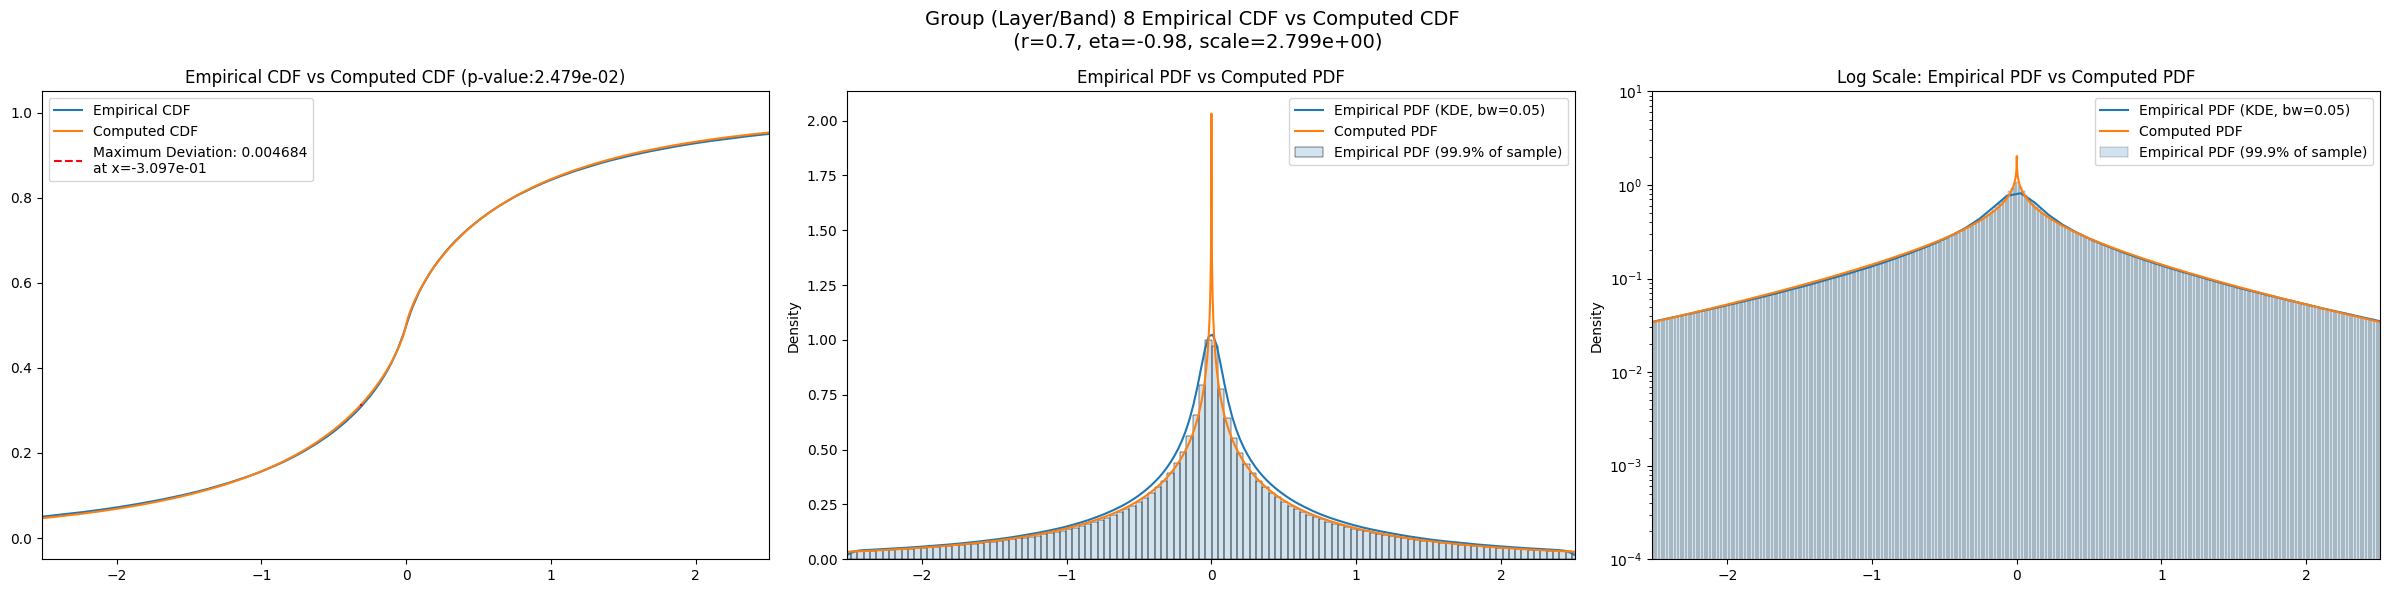

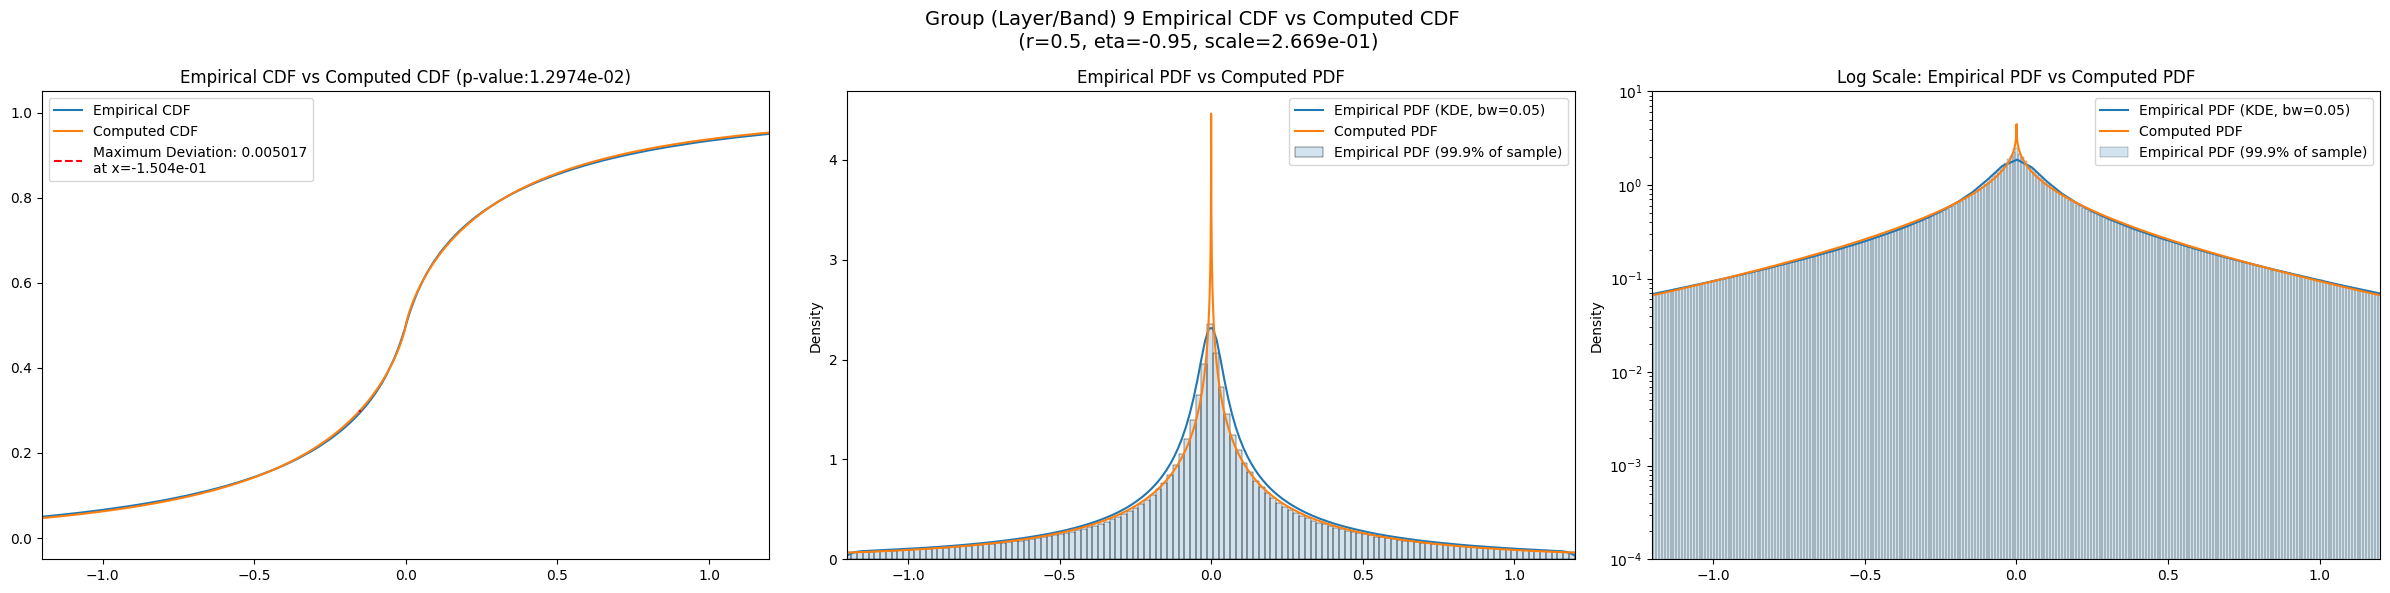

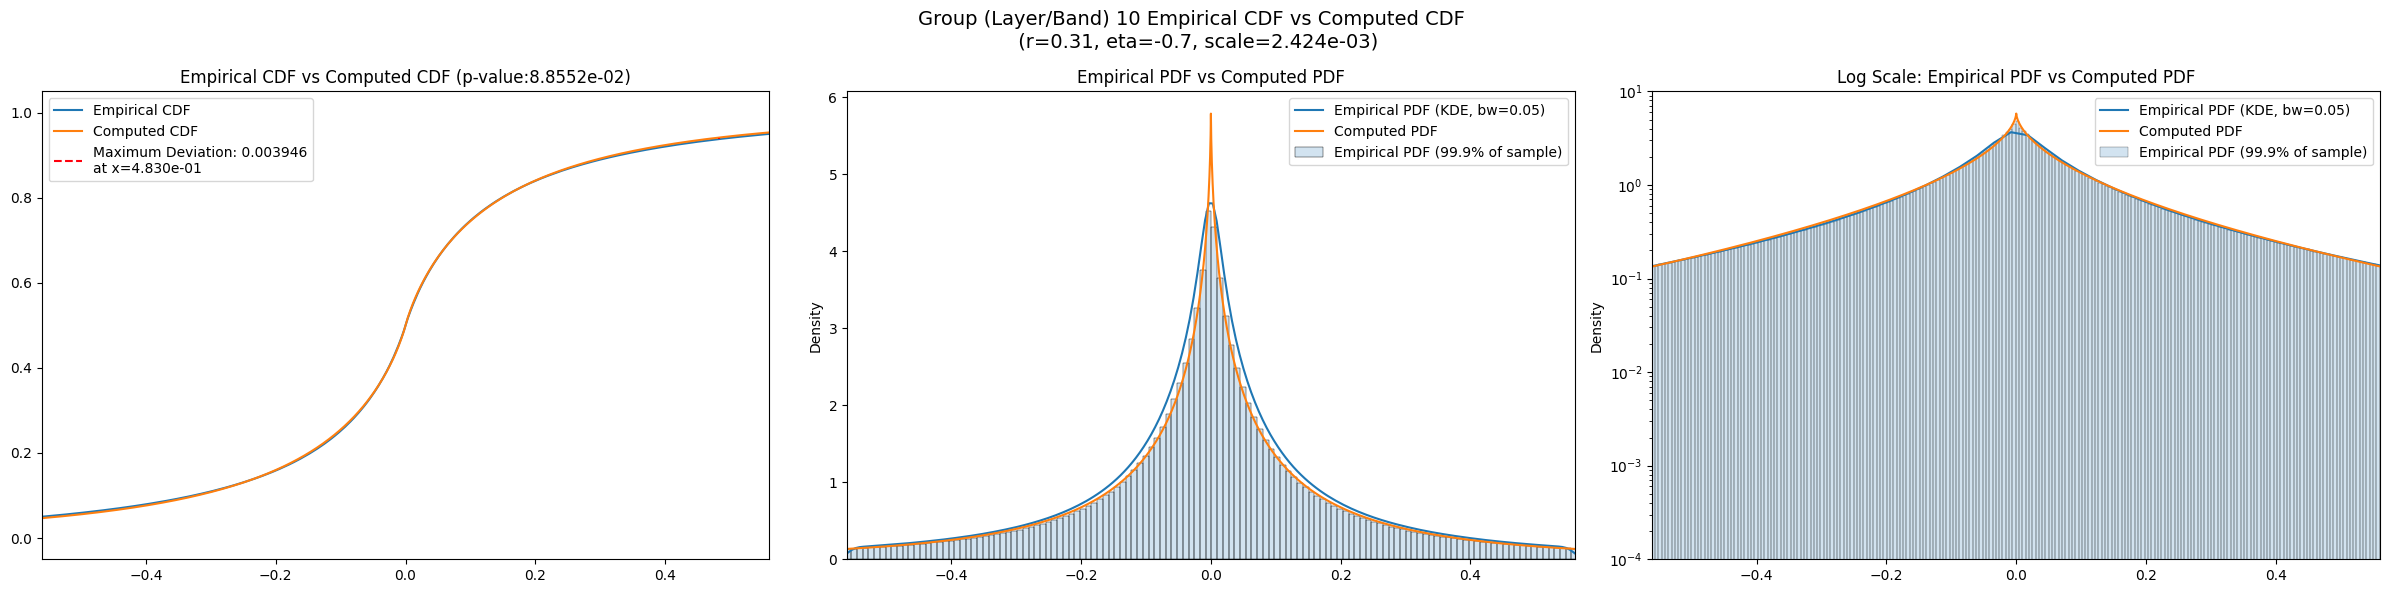

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      16354.510000  15633.312000  17082.553000   0.101962   -0.016666   
3       3922.895300   3744.966800   4103.727000   1.139715    0.928585   
4        930.998170    880.450900    983.070430   2.526734    2.019438   
5        218.603700    205.369100    232.632840   3.912470    2.933228   
6         49.854520     46.540530     53.384290   5.029304    3.773884   
7         11.294209     10.485279     12.181979   6.461322    4.597968   
8          2.590993      2.385578      2.849584   9.492075    5.469928   
9          0.616512      0.562501      0.693044  13.534157    6.594753   
10         0.148877      0.133936      0.172039  20.531488    8.519738   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.226260           7072             0.043105        5.9          0.1   
3        1.379318          28288             0.034704        9.3         -0.5   
4        3.304371         113152             0.027620        0.6         -0.1   
5        7.310871         452608             0.016575        0.6         -0.5   
6        9.386376        1810432             0.009251        0.8         -0.8   
7       13.692297        7241728             0.005251        0.7         -0.9   
8       34.075478       28966912             0.005445        0.8         -1.0   
9       54.788080      115867648             0.006017        0.6         -1.0   
10      90.276040      463470592             0.005016        0.3         -0.7   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      112.841000              0.043271          6.061320e-12   
3      ...       50.364800              0.037915          9.084830e-36   
4      ...       22.634000              0.042316         1.704470e-176   
5      ...       10.332900              0.046317          0.000000e+00   
6      ...        4.644120              0.049579          0.000000e+00   
7      ...        2.062280              0.054192          0.000000e+00   
8      ...        0.915230              0.059257          0.000000e+00   
9      ...        0.410321              0.063919          0.000000e+00   
10     ...        0.193750              0.060654          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2         123.887000             0.046339         1.234540e-13  98.334000   
3          54.278100             0.034699         5.008750e-30  39.468100   
4          21.691500             0.027660         1.218110e-75  16.517000   
5           8.852140             0.020770        4.917500e-170   7.279660   
6           4.013570             0.022806         0.000000e+00   3.248840   
7           1.782460             0.027467         0.000000e+00   1.430630   
8           0.791053             0.032600         0.000000e+00   0.631523   
9           0.356297             0.037026         0.000000e+00   0.282694   
10          0.169801             0.033672         0.000000e+00   0.133675   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.043105   7.424310e-12          7.425588e-12  
3           0.034895   2.317540e-30          4.903671e-30  
4           0.028785   6.933950e-82          2.116599e-75  
5           0.026400  1.824710e-274         9.320875e-108  
6           0.027284   0.000000e+00         8.111483e-128  
7           0.031078   0.000000e+00         7.105993e-150  
8           0.035614   0.000000e+00          0.000000e+00  
9           0.038944   0.000000e+00          0.000000e+00  
10          0.034041   0.000000e+00       

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.043105                 0.016126          0.043105   
3                 0.034704                 0.008069          0.034704   
4                 0.027620                 0.004036          0.027616   
5                 0.016575                 0.002018          0.016522   
6                 0.009251                 0.001009          0.009001   
7                 0.005251                 0.000505          0.004874   
8                 0.005445                 0.000252          0.004684   
9                 0.006017                 0.000126          0.005017   
10                0.005016                 0.000063          0.003946   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.043271             0.046339       0.043105  
3                  0.037915             0.034699       0.034895  
4                  0.042316             0.027660       0.028785  
5                  0.046317             0.020770       0.026400  
6                  0.049579             0.022806       0.027284  
7                  0.054192             0.027467       0.031078  
8                  0.059257             0.032600       0.035614  
9                  0.063919             0.037026       0.038944  
10                 0.060654             0.033672       0.034041

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            16354.510000          0.043105    5.90      0.10  27070.913566   
3             3821.143800          0.034704    9.30     -0.50   7926.867310   
4              850.418335          0.027616    0.79     -0.30    455.694239   
5              190.307312          0.016522    0.60     -0.48     60.097380   
6               44.903885          0.009001    0.70     -0.76     33.097781   
7               11.294209          0.004874    0.60     -0.86      6.873845   
8                2.459400          0.004684    0.70     -0.98      2.799353   
9                0.616512          0.005017    0.50     -0.95      0.266888   
10               0.148877          0.003946    0.31     -0.70      0.002424   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                     25.0  
4                    250.0  
5                    350.0  
6                    200.0  
7                      0.0  
8                     50.0  
9                      0.0  
10                     0.0